In [1]:

%load_ext autoreload
%autoreload 2


In [2]:
import polars as pl 
import numpy as np  
import pandas as pd
from src.config.path import RESULTS_DIR, SRC_DIR, HAMNUCRET_DATA_DIR
from src.config.storage import SimulationStorage
import json
import shutil
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

Source Directory: /home/pol_schiessel/maya620d/pol/Projects/Codebase/Spermatogensis
Output Directory: /home/pol_schiessel/maya620d/pol/Projects/Codebase/Spermatogensis
HAMNUCRET Data Directory: /home/pol_schiessel/maya620d/pol/Projects/Codebase/Spermatogensis/hamnucret_data


In [3]:
import matplotlib as mpl
from pathlib import Path
thesis_dir = Path("/home/pol_schiessel/maya620d/pol/Projects/Thesis")
# --- publication‐style rcParams ---
mpl.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 12,          # base font size (used if specific sizes not given)
    'axes.labelsize': 14,     # x/y label font size
    'axes.labelweight': 'bold',   # make x/y label text bold
    'axes.titlesize': 16,
    'axes.titleweight': 'bold',   # (optional) bold titles too
    'xtick.labelsize': 12,    # tick number font size (x)
    'ytick.labelsize': 12,    # tick number font size (y)
    'axes.linewidth': 1.0,
    'lines.linewidth': 1.5,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 5,
    'ytick.major.size': 5,
    'xtick.minor.size': 3,
    'ytick.minor.size': 3,
    'figure.dpi': 200,
    'savefig.dpi': 200,
    'legend.fontsize': 12,
    'legend.frameon': True,
    'svg.fonttype': 'none',
    # --- added to pull labels closer ---
    'axes.labelpad': 1,        # distance axis spine <-> axis label (default ~4)
    'axes.titlepad': 2,        # distance title <-> top of axes (lower if you want closer)
    'xtick.major.pad': 2,      # distance tick labels <-> axis
    'ytick.major.pad': 2,
    'xtick.minor.pad': 2,
    'ytick.minor.pad': 2,
})

In [59]:
CLUSTER_OUTPUT_DIR = SRC_DIR / "cluster_output"


## **Analysis of the Retained and Evicted Breathing Energies**

In [ ]:
RET_data = HAMNUCRET_DATA_DIR / "exactpoint_boundpromoter_regions_breath/breath_energy/001.tsv"
EVI_data = HAMNUCRET_DATA_DIR / "exactpoint_unboundpromoter_regions_breath/breath_energy/001.tsv"

#### This EVI_data file was created BY using the adhoc_08_filter_data.job file from 
#### the HAMNUCRET cluster project for the 2010-2030 subid range across all the minpointunbound_promoters output data on the cluster.


breath_schema = {
    "dF": pl.Float64,
    "F_freedna": pl.Float64,
    "F_enthalpy": pl.Float64,
    "id": pl.Utf8,
    "subid": pl.Int32,
    "right_open": pl.Int8,
    "left_open": pl.Int8,
    "dF_total": pl.Float64,
}

In [5]:


def scan_breath_energy(path: Path, state: str) -> pl.LazyFrame:
    return (
        pl.scan_csv(
            path,
            separator="\t",
            has_header=True,
            dtypes=breath_schema,
            infer_schema_length=0,   # use provided schema
        )
        .with_columns([
            pl.lit(state).alias("state"),
            pl.col("subid").cast(pl.Int32),
        ])
    )

RET_lf = scan_breath_energy(RET_data, "retained")     # lazy frame
EVI_lf = scan_breath_energy(EVI_data, "evicted")


# Peek at a few rows (collect only small sample)
print(RET_lf.count().collect())
print(EVI_lf.count().collect())

shape: (1, 9)
┌─────────┬────────────┬───────────┬─────────┬───┬────────────┬───────────┬──────────┬─────────┐
│ dF      ┆ F_enthalpy ┆ F_freedna ┆ id      ┆ … ┆ right_open ┆ left_open ┆ dF_total ┆ state   │
│ ---     ┆ ---        ┆ ---       ┆ ---     ┆   ┆ ---        ┆ ---       ┆ ---      ┆ ---     │
│ u32     ┆ u32        ┆ u32       ┆ u32     ┆   ┆ u32        ┆ u32       ┆ u32      ┆ u32     │
╞═════════╪════════════╪═══════════╪═════════╪═══╪════════════╪═══════════╪══════════╪═════════╡
│ 1921080 ┆ 1921080    ┆ 1921080   ┆ 1921080 ┆ … ┆ 1921080    ┆ 1921080   ┆ 1921080  ┆ 1921080 │
└─────────┴────────────┴───────────┴─────────┴───┴────────────┴───────────┴──────────┴─────────┘
shape: (1, 9)
┌─────────┬───────────┬────────────┬─────────┬───┬────────────┬───────────┬──────────┬─────────┐
│ dF      ┆ F_freedna ┆ F_enthalpy ┆ id      ┆ … ┆ right_open ┆ left_open ┆ dF_total ┆ state   │
│ ---     ┆ ---       ┆ ---        ┆ ---     ┆   ┆ ---        ┆ ---       ┆ ---      ┆ ---     │
│ 

/tmp/ipykernel_3523548/226765211.py:3: DeprecationWarning: the argument `dtypes` for `scan_csv` is deprecated. It was renamed to `schema_overrides` in version 0.20.31.
  pl.scan_csv(


In [6]:
# After defining EVI_lf:

# 1. For each (id, subid) compute the minimum dF_total where both openings are 0
EVI_candidates_lf = (
    EVI_lf
    .filter( (pl.col("right_open") == 0) & (pl.col("left_open") == 0) )
    .group_by(["id", "subid"])
    .agg(pl.min("dF_total").alias("subid_min_dF_total"))
)

# 2. For each id pick the subid with the lowest subid_min_dF_total
best_subid_per_id_lf = (
    EVI_candidates_lf
    .sort(["id", "subid_min_dF_total"])   # ensures smallest first within each id
    .group_by("id")
    .agg(pl.first("subid").alias("subid"))  # keep only best subid per id
)

# 3. Keep only rows from original EVI_lf that belong to the chosen subids
EVI_filtered_lf = (
    EVI_lf
    .join(best_subid_per_id_lf, on=["id", "subid"], how="inner")
)

# (Optional) collect to inspect
print(EVI_filtered_lf.count().collect())

shape: (1, 9)
┌─────────┬───────────┬────────────┬─────────┬───┬────────────┬───────────┬──────────┬─────────┐
│ dF      ┆ F_freedna ┆ F_enthalpy ┆ id      ┆ … ┆ right_open ┆ left_open ┆ dF_total ┆ state   │
│ ---     ┆ ---       ┆ ---        ┆ ---     ┆   ┆ ---        ┆ ---       ┆ ---      ┆ ---     │
│ u32     ┆ u32       ┆ u32        ┆ u32     ┆   ┆ u32        ┆ u32       ┆ u32      ┆ u32     │
╞═════════╪═══════════╪════════════╪═════════╪═══╪════════════╪═══════════╪══════════╪═════════╡
│ 1199880 ┆ 1199880   ┆ 1199880    ┆ 1199880 ┆ … ┆ 1199880    ┆ 1199880   ┆ 1199880  ┆ 1199880 │
└─────────┴───────────┴────────────┴─────────┴───┴────────────┴───────────┴──────────┴─────────┘


In [44]:
EVI_OUT_PATH = RESULTS_DIR / "001_EVI_filtered.tsv"
EVI_OUT_PATH.parent.mkdir(parents=True, exist_ok=True)

# Option A (works in all versions): collect then write
EVI_filtered_df = EVI_filtered_lf.drop("state").collect(engine="streaming")
EVI_filtered_df.write_csv(EVI_OUT_PATH, separator="\t")

shape: (20, 4)
┌────────────────────┬───────┬───────────────┬───────┐
│ id                 ┆ subid ┆ mean_dF_total ┆ state │
│ ---                ┆ ---   ┆ ---           ┆ ---   │
│ str                ┆ i32   ┆ f64           ┆ str   │
╞════════════════════╪═══════╪═══════════════╪═══════╡
│ ENST00000245903.4  ┆ 2013  ┆ -5.709523     ┆ EVI   │
│ ENST00000402673.7  ┆ 2011  ┆ -3.584895     ┆ EVI   │
│ ENST00000689909.1  ┆ 2011  ┆ 2.418583      ┆ EVI   │
│ ENST00000601181.6  ┆ 2026  ┆ 1.297259      ┆ EVI   │
│ ENST00000614907.3  ┆ 2019  ┆ -2.088526     ┆ EVI   │
│ …                  ┆ …     ┆ …             ┆ …     │
│ ENST00000296849.10 ┆ 2020  ┆ -12.640893    ┆ EVI   │
│ ENST00000396878.8  ┆ 2021  ┆ -12.562065    ┆ EVI   │
│ ENST00000164139.4  ┆ 2013  ┆ -3.797732     ┆ EVI   │
│ ENST00000340473.8  ┆ 2030  ┆ -6.802426     ┆ EVI   │
│ ENST00000300917.10 ┆ 2020  ┆ -5.953709     ┆ EVI   │
└────────────────────┴───────┴───────────────┴───────┘
shape: (5, 4)
┌────────────────────┬───────┬──────

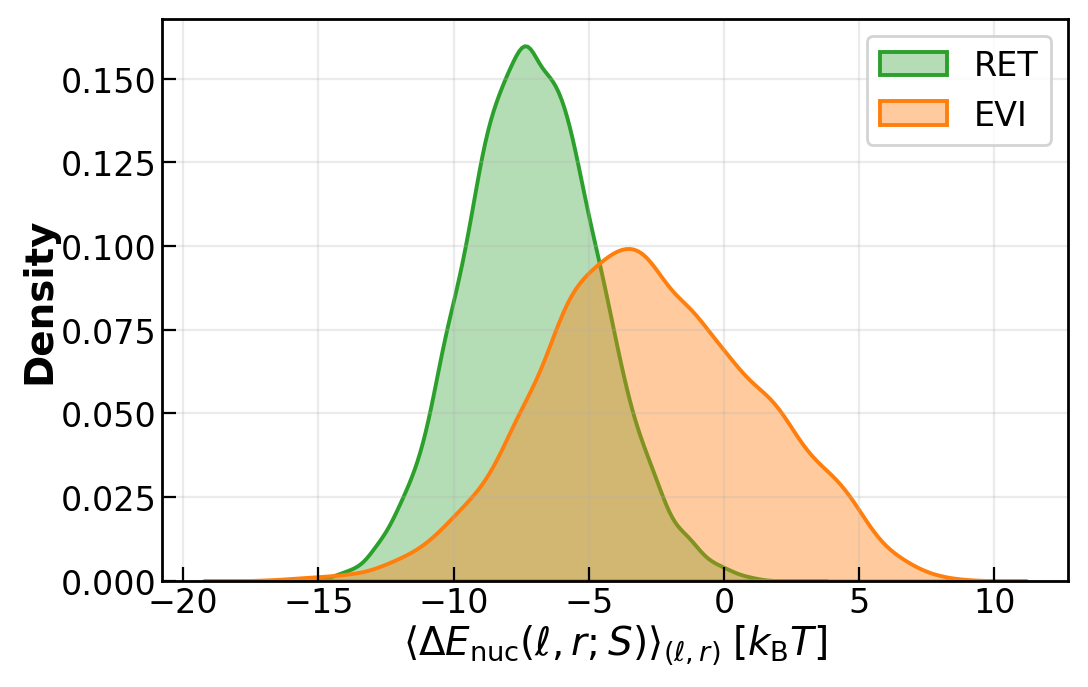

In [141]:
# --- Aggregate mean dF_total per (id, subid) for RET & EVI and plot distributions ---

# 1. Build lazy grouped frames (stay lazy until final collect)
RET_mean_lf = (
    RET_lf
    .group_by(["id", "subid"])        # state already known (RET)
    .agg(pl.mean("dF_total").alias("mean_dF_total"))
    # .filter( (pl.col("subid") > 2080) & (pl.col("subid") < 2090) )
    .with_columns(pl.lit("RET").alias("state"))
)

EVI_mean_lf = (
    EVI_filtered_lf
    .group_by(["id", "subid"])
    .agg(pl.mean("dF_total").alias("mean_dF_total"))
    .with_columns(pl.lit("EVI").alias("state"))
)

print(EVI_mean_lf.limit(20).collect())

# 2. Combine (still lazy) then collect (streaming for lower memory)
combined_mean = pl.concat([RET_mean_lf, EVI_mean_lf])
combined_df = combined_mean.collect(engine="streaming")

print(combined_df.head())

# 3. Plot distributions
pdf = combined_df.to_pandas()



# Base colors keyed by display label
base_colors = {"RET": "tab:green", "EVI": "tab:orange"}

fig, ax = plt.subplots(figsize=(5.6, 3.6))
sns.kdeplot(
    data=RET_mean_lf.collect(engine="streaming").to_pandas(),
    x="mean_dF_total",
    label="RET",
    color="tab:green",
    fill=True,
    common_norm=False,
    alpha=0.35,
    linewidth=1.4,
    ax=ax
)


sns.kdeplot(
    data=EVI_mean_lf.collect(engine="streaming").to_pandas(),
    x="mean_dF_total",
    label="EVI",
    color="tab:orange",
    fill=True,
    common_norm=False,
    alpha=0.4,
    linewidth=1.4,
    ax=ax
)


x_label = r'$\langle \Delta E_{\mathrm{nuc}}(\ell,r;S)\rangle_{(\ell,r)}\;[k_{\mathrm{B}}T]$'
ax.set_xlabel(x_label)
ax.set_ylabel("Density")
ax.grid(alpha=0.25)
ax.legend(framealpha=0.85, labels=["RET", "EVI"])


plt.tight_layout()
plt.show()

save_path = thesis_dir / "Chapter_HistProt" / "SSA"
for ext in ("png", "pdf", "svg"):
    fig.savefig(save_path / f"mean_lrS_energy.{ext}", dpi=300, bbox_inches="tight", transparent=True)
# ...existing code...
# # (Optional) Overlaid histograms instead / additionally:
# plt.figure(figsize=(7,4.2))
# bins = 40
# for state, color in [("RET","tab:green"), ("EVI","tab:orange")]:
#     subset = pdf[pdf.state == state]["mean_dF_total"]
#     plt.hist(subset, bins=bins, alpha=0.45, density=True, label=state, color=color)
# plt.xlabel("Mean dF_total per (id, subid)")
# plt.ylabel("Density")
# plt.title("Histogram of mean dF_total (RET vs EVI)")
# plt.legend()
# plt.grid(alpha=0.25)
# plt.tight_layout()
# plt.show()

In [8]:
print(EVI_filtered_lf.select("id", "subid").unique().count().collect())
print(RET_lf.select("id", "subid").unique().count().collect())


shape: (1, 2)
┌──────┬───────┐
│ id   ┆ subid │
│ ---  ┆ ---   │
│ u32  ┆ u32   │
╞══════╪═══════╡
│ 9999 ┆ 9999  │
└──────┴───────┘
shape: (1, 2)
┌───────┬───────┐
│ id    ┆ subid │
│ ---   ┆ ---   │
│ u32   ┆ u32   │
╞═══════╪═══════╡
│ 16009 ┆ 16009 │
└───────┴───────┘


In [52]:
res = EVI_filtered_lf.select([
    pl.col("subid").min().alias("min_subid"),
    pl.col("subid").max().alias("max_subid"),
]).collect(engine="streaming")

min_subid = res["min_subid"][0]
max_subid = res["max_subid"][0]
print(f"EVI_filtered_lf.subid -> min: {min_subid}, max: {max_subid}")

EVI_filtered_lf.subid -> min: 2010, max: 2030


#### Get the subset of the idlookup from the minpointunbound_promoters output data on the cluster for min: 2010, max: 2030

In [55]:
unique_EVI_ids = EVI_filtered_lf.select("id", "subid").unique().collect()

In [56]:
unique_EVI_ids

id,subid
str,i32
"""ENST00000380750.8""",2028
"""ENST00000503143.3""",2021
"""ENST00000259056.5""",2020
"""ENST00000315274.7""",2020
"""ENST00000257867.5""",2023
…,…
"""ENST00000380993.8""",2015
"""ENST00000229214.9""",2027
"""ENST00000320585.11""",2015


In [60]:
# ...existing code...
from pathlib import Path
import numpy as np
import pandas as pd

fasta_path = CLUSTER_OUTPUT_DIR / "exactpoint_unboundpromoter_regions_breath/exactunbound_prom_sequences.fa"
# out_tsv = Path("EVI_matched_sequences_GC.tsv")

# prepare set of (id, subid) from unique_EVI_ids (polars DataFrame collected earlier)
try:
    # unique_EVI_ids is expected to be a Polars/DataFrame collected earlier in the notebook
    if 'unique_EVI_ids' in globals():
        try:
            uid_df = unique_EVI_ids.to_pandas()   # if polars
        except Exception:
            uid_df = pd.DataFrame(unique_EVI_ids)  # if already pandas-like
    else:
        # fallback: try EVI_filtered_df if present
        uid_df = EVI_filtered_df.select(["id","subid"]).to_pandas() if 'EVI_filtered_df' in globals() else None

    if uid_df is None:
        raise NameError("unique_EVI_ids / EVI_filtered_df not found in namespace.")
except Exception as e:
    raise RuntimeError("Could not load unique_EVI_ids from notebook state: " + str(e))

# normalize types and build lookup set
uid_df['subid'] = uid_df['subid'].astype(int)
uid_df['id'] = uid_df['id'].astype(str)
lookup = set(zip(uid_df['id'].tolist(), uid_df['subid'].tolist()))

# parser for FASTA
def parse_fasta(path):
    with open(path, 'rt') as fh:
        header = None
        seq_chunks = []
        for line in fh:
            line = line.rstrip('\n')
            if not line:
                continue
            if line.startswith('>'):
                if header is not None:
                    yield header, ''.join(seq_chunks)
                header = line[1:].strip()
                seq_chunks = []
            else:
                seq_chunks.append(line.strip())
        if header is not None:
            yield header, ''.join(seq_chunks)

matches = []
for header, seq in parse_fasta(fasta_path):
    parts = header.split('|')
    # guard against unexpected header formats
    if len(parts) < 5:
        continue
    seq_id = parts[1].strip()                     # second field
    pos_field = parts[4].strip()                  # fifth field, e.g. "pos:2018"
    try:
        subid = int(pos_field.split(':',1)[1])
    except Exception:
        # skip if cannot parse subid
        continue

    if (seq_id, subid) in lookup:
        s = seq.upper()
        gc_count = s.count('G') + s.count('C')
        atgc_count = sum(s.count(x) for x in ("A","T","G","C"))
        gc_frac = (gc_count / atgc_count) if atgc_count > 0 else np.nan
        matches.append({
            "header": header,
            "id": seq_id,
            "subid": subid,
            "seq_len": len(s),
            "atgc_len": atgc_count,
            "gc_count": gc_count,
            "gc_frac": float(gc_frac)
        })

# results
matched_df = pd.DataFrame(matches).sort_values(["id","subid"]).reset_index(drop=True)
print(f"Found {len(matched_df)} matching sequences out of {len(lookup)} lookup pairs.")
display(matched_df.head())



Found 9999 matching sequences out of 9999 lookup pairs.


,header,id,subid,seq_len,atgc_len,gc_count,gc_frac
0,chr12:8947644-8951645|ENST00000000412.8|-|8949...,ENST00000000412.8,2016,147,147,93,0.632653
1,chr2:37229657-37233658|ENST00000002125.9|+|372...,ENST00000002125.9,2014,147,147,96,0.653061
2,chr1:24413802-24417803|ENST00000003912.8|+|244...,ENST00000003912.8,2024,147,147,73,0.496599
3,chr19:35755028-35759029|ENST00000004982.6|-|35...,ENST00000004982.6,2030,147,147,110,0.748299
4,chr7:75770210-75774211|ENST00000005180.9|-|757...,ENST00000005180.9,2025,147,147,90,0.612245


Found 9999 matching EVI sequences (lookup size 9999)
Found 16009 matching RET sequences (lookup size 16009)


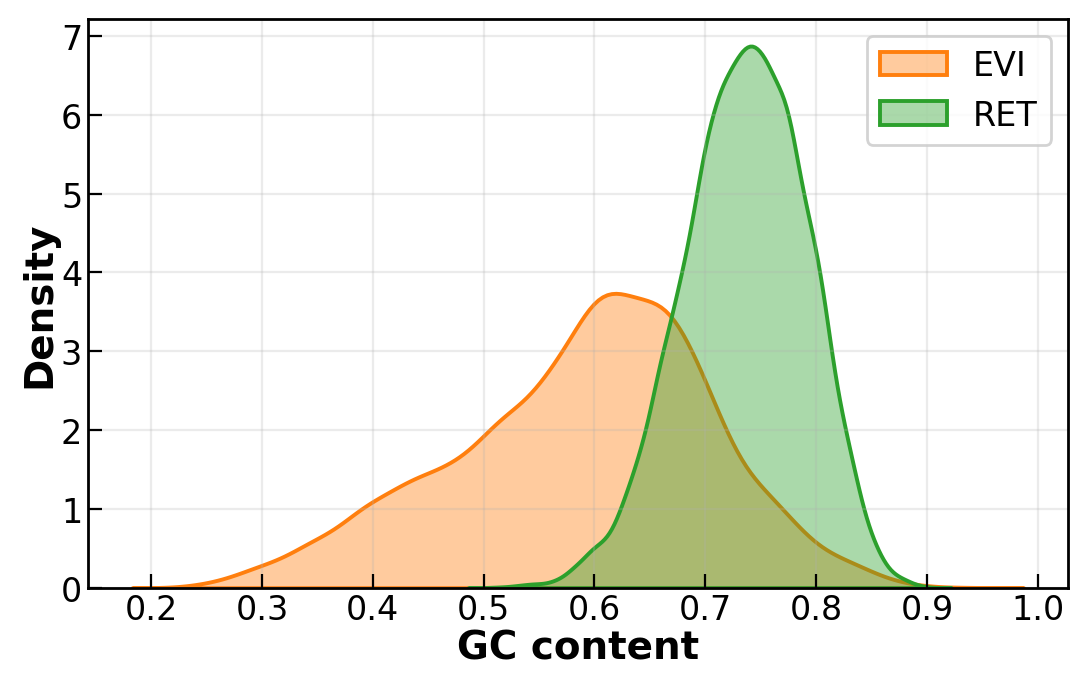

(                                                 header                 id  \
 0     chr12:8947644-8951645|ENST00000000412.8|-|8949...  ENST00000000412.8   
 1     chr2:37229657-37233658|ENST00000002125.9|+|372...  ENST00000002125.9   
 2     chr1:24413802-24417803|ENST00000003912.8|+|244...  ENST00000003912.8   
 3     chr19:35755028-35759029|ENST00000004982.6|-|35...  ENST00000004982.6   
 4     chr7:75770210-75774211|ENST00000005180.9|-|757...  ENST00000005180.9   
 ...                                                 ...                ...   
 9994  chr5:70485718-70489719|ENST00000718364.1|+|704...  ENST00000718364.1   
 9995  chr12:31747390-31751391|ENST00000850643.1|+|31...  ENST00000850643.1   
 9996  chrY:1266792-1270793|ENST00000850688.1|+|12687...  ENST00000850688.1   
 9997  chrY:316797-320798|ENST00000850822.1|-|318798|...  ENST00000850822.1   
 9998  chrY:57182225-57186226|ENST00000850823.1|+|571...  ENST00000850823.1   
 
       subid  seq_len  atgc_len  gc_count   gc_fra

In [120]:
# ...existing code...
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def fasta_gc_for_lookup(fasta_path: Path, lookup_pairs: set):
    """
    Parse fasta at fasta_path. Header expected with '|' separators where
    parts[1] is id and parts[4] is 'pos:SUBID'. Return DataFrame of matches
    with GC fraction (ignoring Ns).
    """
    def parse_fasta(path):
        with open(path, 'rt') as fh:
            header = None
            seq_chunks = []
            for line in fh:
                line = line.rstrip('\n')
                if not line:
                    continue
                if line.startswith('>'):
                    if header is not None:
                        yield header, ''.join(seq_chunks)
                    header = line[1:].strip()
                    seq_chunks = []
                else:
                    seq_chunks.append(line.strip())
            if header is not None:
                yield header, ''.join(seq_chunks)

    matches = []
    for header, seq in parse_fasta(fasta_path):
        parts = header.split('|')
        if len(parts) < 5:
            continue
        seq_id = parts[1].strip()
        pos_field = parts[4].strip()
        try:
            subid = int(pos_field.split(':', 1)[1])
        except Exception:
            continue
        if (seq_id, subid) in lookup_pairs:
            s = seq.upper()
            gc_count = s.count('G') + s.count('C')
            atgc_count = sum(s.count(x) for x in ("A","T","G","C"))
            gc_frac = (gc_count / atgc_count) if atgc_count > 0 else np.nan
            matches.append({
                "header": header,
                "id": seq_id,
                "subid": subid,
                "seq_len": len(s),
                "atgc_len": atgc_count,
                "gc_count": gc_count,
                "gc_frac": float(gc_frac)
            })
    if not matches:
        return pd.DataFrame(columns=["header","id","subid","seq_len","atgc_len","gc_count","gc_frac"])
    return pd.DataFrame(matches).sort_values(["id","subid"]).reset_index(drop=True)

# Build lookup sets from notebook Polars objects (unique_EVI_ids and RET_lf)
# EVI
if 'unique_EVI_ids' in globals():
    try:
        uid_df = unique_EVI_ids.to_pandas()
    except Exception:
        uid_df = pd.DataFrame(unique_EVI_ids)
else:
    uid_df = EVI_filtered_df.select(["id","subid"]).to_pandas() if 'EVI_filtered_df' in globals() else pd.DataFrame(columns=["id","subid"])

uid_df['id'] = uid_df['id'].astype(str)
uid_df['subid'] = uid_df['subid'].astype(int)
lookup_evi = set(zip(uid_df['id'].tolist(), uid_df['subid'].tolist()))

# RET: collect unique (id, subid) from the RET lazyframe
try:
    unique_RET_ids = RET_lf.select("id","subid").unique().collect()
    try:
        ret_uid_df = unique_RET_ids.to_pandas()
    except Exception:
        ret_uid_df = pd.DataFrame(unique_RET_ids)
except Exception:
    # fallback: if an eager RET dataframe exists
    ret_uid_df = RET_lf.collect().select(["id","subid"]).to_pandas() if 'RET_lf' in globals() else pd.DataFrame(columns=["id","subid"])

ret_uid_df['id'] = ret_uid_df['id'].astype(str)
ret_uid_df['subid'] = ret_uid_df['subid'].astype(int)
lookup_ret = set(zip(ret_uid_df['id'].tolist(), ret_uid_df['subid'].tolist()))

# fasta file paths (absolute from prompt)
fasta_evi = CLUSTER_OUTPUT_DIR / "exactpoint_unboundpromoter_regions_breath/exactunbound_prom_sequences.fa"
fasta_ret = CLUSTER_OUTPUT_DIR / "exactpoint_boundpromoter_regions_breath/boundprom_exactpoints.part_001.fa"

matched_evi_df = fasta_gc_for_lookup(fasta_evi, lookup_evi)
matched_ret_df = fasta_gc_for_lookup(fasta_ret, lookup_ret)

print(f"Found {len(matched_evi_df)} matching EVI sequences (lookup size {len(lookup_evi)})")
print(f"Found {len(matched_ret_df)} matching RET sequences (lookup size {len(lookup_ret)})")

# Plot GC distribution (drop NaNs)
evi_gc = matched_evi_df['gc_frac'].dropna()
ret_gc = matched_ret_df['gc_frac'].dropna()

fig, ax = plt.subplots(figsize=(5.6, 3.6))

sns.kdeplot(evi_gc, fill=True, common_norm=False, alpha=0.4, label="EVI", color="tab:orange", linewidth=1.4)
sns.kdeplot(ret_gc, fill=True, common_norm=False, alpha=0.4, label="RET", color="tab:green", linewidth=1.4)
# sns.rugplot(evi_gc, color="tab:orange", alpha=0.2)
# sns.rugplot(ret_gc, color="tab:green", alpha=0.2)
ax.set_xlabel("GC content")
ax.set_ylabel("Density")
# plt.title("GC content distribution: RET vs EVI")
ax.legend(framealpha=0.85)
ax.grid(alpha=0.25)
plt.tight_layout()
plt.show()
save_path = thesis_dir / "Chapter_HistProt" / "SSA"

if save_path is not None:
    # save_path.parent.mkdir(parents=True, exist_ok=True)
    for ext in ("png", "pdf", "svg"):
        # For PDF/SVG, rasterize to preserve sharpness
        fig.savefig(save_path / f"GC_content_RET_EVI.{ext}", dpi=300, bbox_inches="tight", transparent=True)


# (optional) expose dataframes for later use
matched_evi_df, matched_ret_df
# ...existing code...

In [136]:
RET_lf.collect().head()

dF,F_enthalpy,F_freedna,id,subid,right_open,left_open,dF_total,state
f64,f64,f64,str,i32,i8,i8,f64,str
197.046,1653.964786,60.86465,"""ENST00000000233.10""",2086,0,0,-31.434,"""retained"""
183.67,1653.964786,57.08065,"""ENST00000000233.10""",2086,1,0,-28.49,"""retained"""
176.542,1653.964786,53.470457,"""ENST00000000233.10""",2086,2,0,-19.298,"""retained"""
161.986,1653.964786,47.354232,"""ENST00000000233.10""",2086,3,0,-17.534,"""retained"""
154.402,1653.964786,43.021783,"""ENST00000000233.10""",2086,4,0,-8.798,"""retained"""


RET sequences -> 16009 (kept with >=2 states)
EVI sequences -> 9999 (kept with >=2 states)


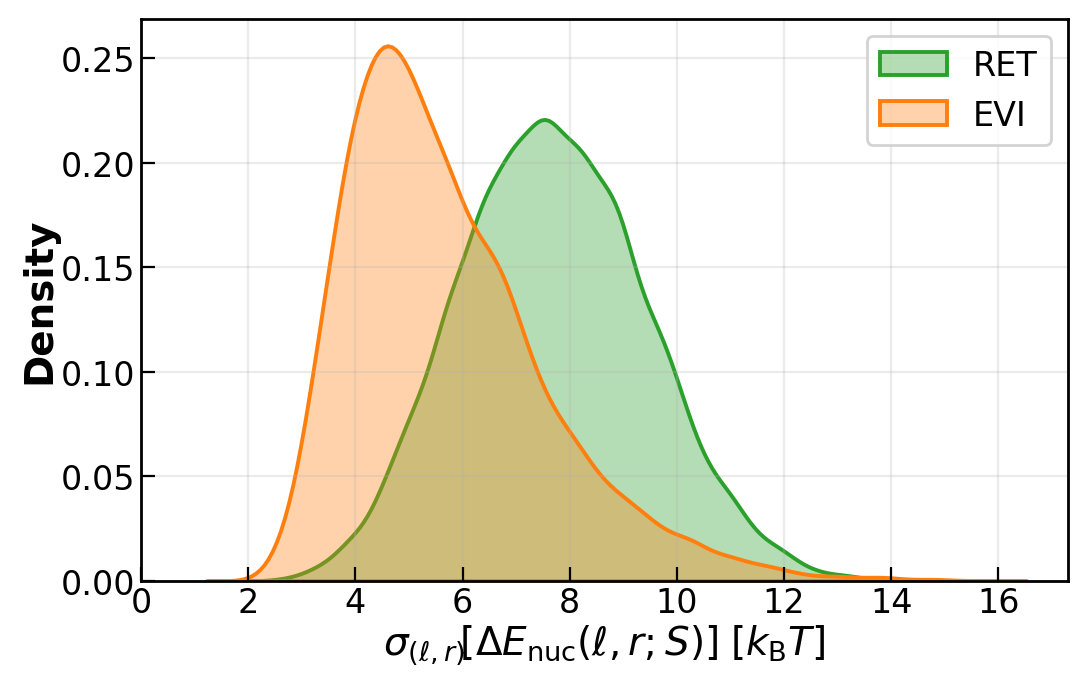

In [ ]:
# ...existing code...
# --- per-sequence energy-metrics and density plots (RET vs EVI) ---
import seaborn as sns
import matplotlib.pyplot as plt

# ...existing code...
def compute_seq_energy_metrics(lazy_df: pl.LazyFrame, value_col: str = "dF_total", state_label: str = "RET"):
    """
    Compute per-sequence (per id) var, std, range and n_states using Polars lazy ops,
    then collect to a pandas DataFrame. Drops sequences with n_states < 2.
    """
    # perform grouping & aggregation while still lazy, then collect (streaming)
    agg_lf = (
        lazy_df
        .select(["id", "subid", value_col])
        .group_by("id", "subid")
        .agg([
            pl.col(value_col).var().alias("var"),
            pl.col(value_col).std().alias("std"),
            (pl.col(value_col).max() - pl.col(value_col).min()).alias("range"),
            pl.col(value_col).count().alias("n_states")
        ])
        .with_columns(pl.lit(state_label).alias("state"))
    )

    pdf = agg_lf.collect(engine="streaming").to_pandas()
    # remove sequences with insufficient samples for var/std (n_states < 2)
    pdf = pdf[pdf["n_states"] >= 2].reset_index(drop=True)
    return pdf
# ...existing code...

# compute metrics for RET and EVI (use EVI_filtered_lf to match earlier filtering)
ret_metrics = compute_seq_energy_metrics(RET_lf, value_col="dF_total", state_label="RET")
evi_metrics = compute_seq_energy_metrics(EVI_filtered_lf, value_col="dF_total", state_label="EVI")

# Quick sanity
print(f"RET sequences -> {len(ret_metrics)} (kept with >=2 states)")
print(f"EVI sequences -> {len(evi_metrics)} (kept with >=2 states)")
# metrics_df = pd.concat([ret_metrics, evi_metrics], ignore_index=True)
# print(metrics_df.head())

# --- Per‑sequence nucleosome energy roughness (only std) ---

palette = {"RET": "tab:green", "EVI": "tab:orange"}

fig, ax = plt.subplots(figsize=(5.6, 3.6))
sns.kdeplot(
    data=ret_metrics,
    x="std",
    label = "RET",
    color = "tab:green",
    fill=True,
    common_norm=False,
    alpha=0.35,
    linewidth=1.4,
    ax=ax
)
sns.kdeplot(
    data=evi_metrics,
    x="std",
    label = "EVI",
    color = "tab:orange",
    fill=True,
    common_norm=False,
    alpha=0.35,
    linewidth=1.4,
    ax=ax
)

x_label = r'$\sigma_{(\ell,r)}\!\left[\Delta E_{\mathrm{nuc}}(\ell,r,S)\right]\;[k_{\mathrm{B}}T]$' 
###Use this in inkscape for bold math: $\bm{\sigma_{(\ell,r)}\!\left[E_{\mathrm{nuc}}(\ell,r,S)\right]\;[k_{\mathrm{B}}T]}$
ax.set_xlabel(x_label)
ax.set_ylabel("Density")
ax.set_xlim(left=0)
ax.grid(alpha=0.25)
ax.legend(framealpha=0.85, labels=["RET", "EVI"])

plt.tight_layout()
plt.show()

save_path = thesis_dir / "Chapter_HistProt" / "SSA"

if save_path is not None:
    # save_path.parent.mkdir(parents=True, exist_ok=True)
    for ext in ("png", "pdf", "svg"):
        # For PDF/SVG, rasterize to preserve sharpness
        fig.savefig(save_path / f"std_lrS_energy.{ext}", dpi=300, bbox_inches="tight", transparent=True)


# (Optional) Print simple summary stats
# print("\nSummary (median, 90th percentile) for each metric:")
# for col in ["std", "var", "range"]:
#     s = metrics_df.groupby("state")[col].agg(["median", lambda x: np.percentile(x.dropna(), 90)])
#     s.columns = ["median", "p90"]
#     print(f"\n{col}:\n", s)
# # ...existing code...

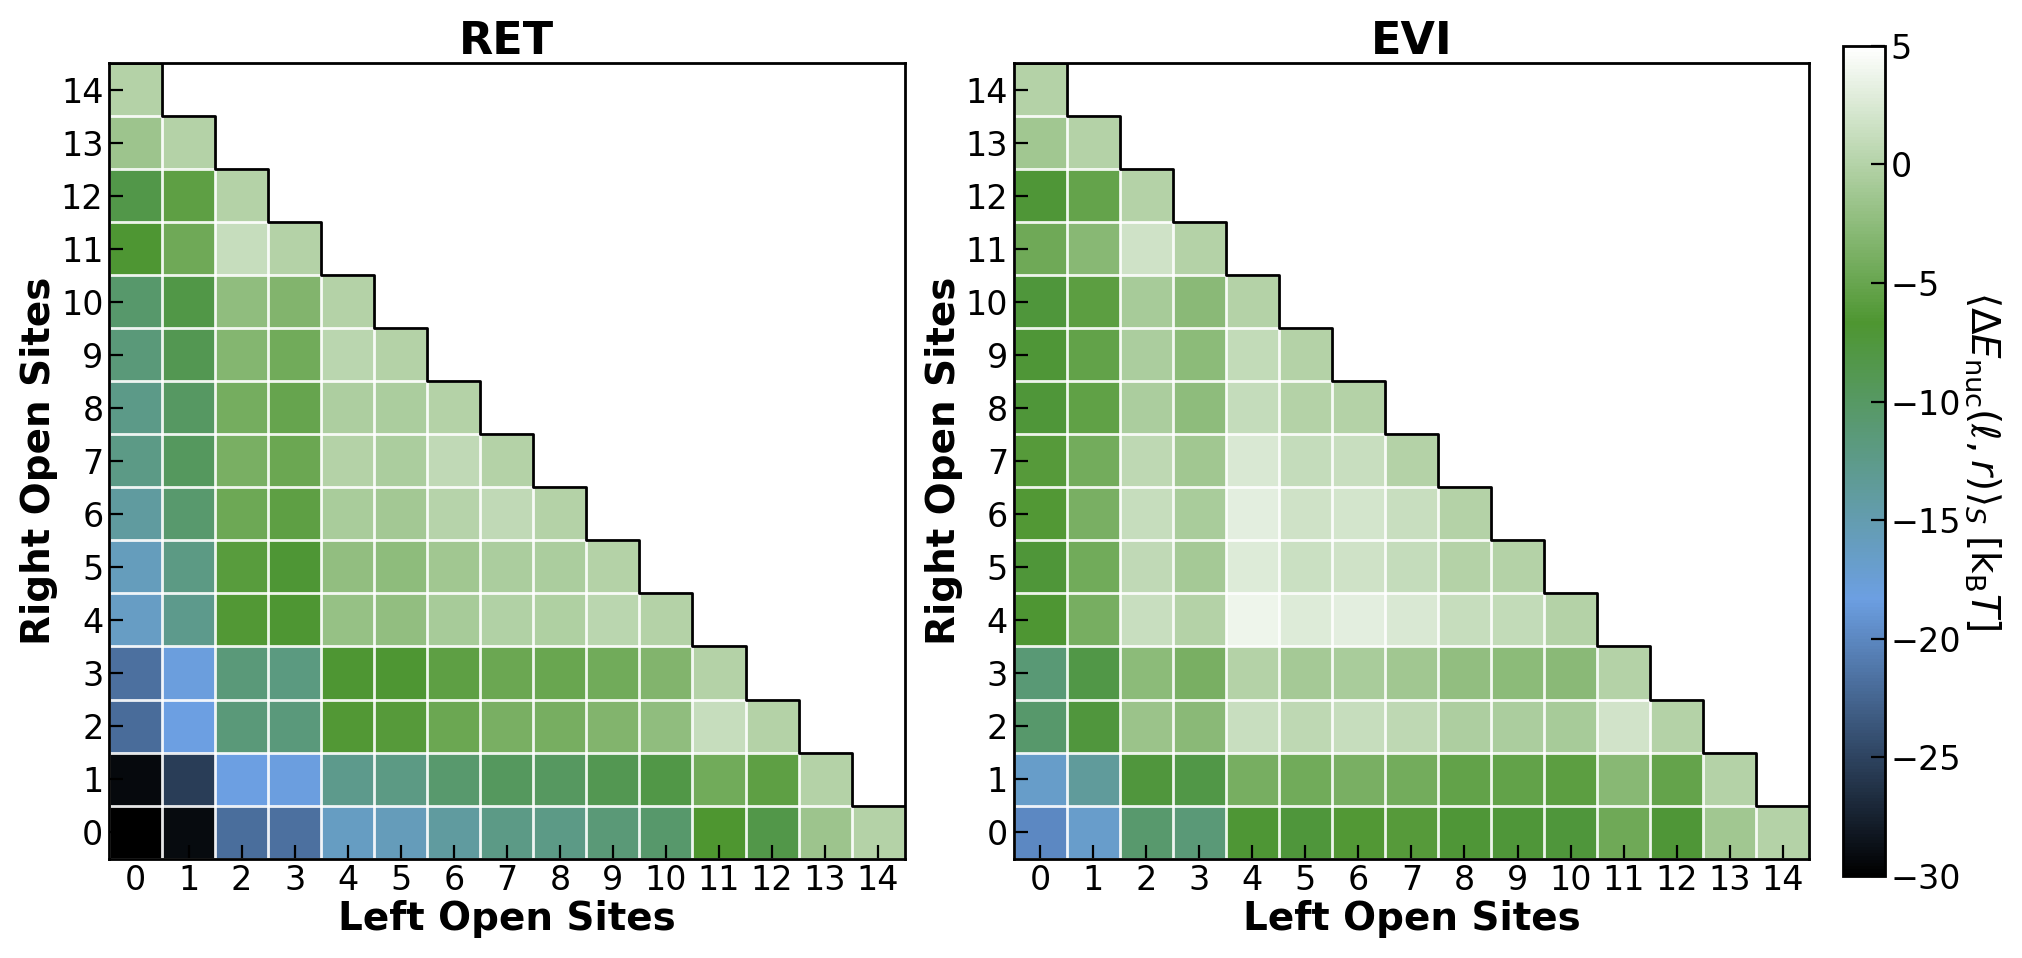

In [142]:
# ...existing code...
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import polars as pl  # Assuming this is imported elsewhere; added for completeness

def _mean_dF_by_opening(lf: pl.LazyFrame) -> pd.DataFrame:
    """
    Aggregate lazyframe by (left_open, right_open) and return a pandas pivot
    table with index=right_open, columns=left_open and values=mean dF_total.
    """
    agg = (
        lf
        .select(["left_open", "right_open", "dF_total"])
        .group_by(["left_open", "right_open"])
        .agg(pl.mean("dF_total").alias("mean_dF"))
        .collect(engine="streaming")
    )
    pdf = agg.to_pandas()
    pivot = pdf.pivot(index="right_open", columns="left_open", values="mean_dF")
    # sort axes to get increasing coordinates
    pivot = pivot.sort_index(axis=0).sort_index(axis=1)
    return pivot

def plot_opening_heatmaps(ret_lf: pl.LazyFrame,
                          evi_lf: pl.LazyFrame,
                          cmap: str = "coolwarm",
                          cmap_colors: list = None,   # optional list of colors (overrides `cmap` name)
                          vmin_cutoff: float = None, # explicit min cutoff (use None to auto)
                          vmax_cutoff: float = None, # explicit max cutoff (use None to auto)
                          annot: bool = False,   # no numbers by default
                          fmt: str = ".2f",
                          figsize=(15, 7),  # Increased size for larger cells to better reveal ruggedness
                          save_path: Path = None,
                          y_max: int = 14,
                          linewidth: float = 1.0):  # Added parameter for grid line thickness
    """
    Compute mean dF_total per (left_open, right_open) for RET and EVI and plot two
    heatmaps side-by-side using a common color scale (centered at zero by default).

    Features:
    - `vmin_cutoff` / `vmax_cutoff` let you clamp the color scale (partial specification
      keeps the scale symmetric around zero).
    - `cmap_colors` accepts a list of color strings to create a custom continuous colormap.
    - Single shared colorbar with label.
    - Grid lines drawn on minor ticks so they lie between cells (white cell boundaries).
    - NaN / missing cells are shown in lightgray.
    Returns (pivot_ret, pivot_evi).
    """
    pivot_ret = _mean_dF_by_opening(ret_lf)
    pivot_evi = _mean_dF_by_opening(evi_lf)

    # Reindex to ensure full 0..y_max rows/cols are present (missing entries -> NaN)
    full_idx = np.arange(0, y_max + 1)
    pivot_ret = pivot_ret.reindex(index=full_idx, columns=full_idx)
    pivot_evi = pivot_evi.reindex(index=full_idx, columns=full_idx)

    # Convert to numpy arrays (NaNs will be masked for imshow)
    data_ret = pivot_ret.to_numpy()
    data_evi = pivot_evi.to_numpy()

    # determine automatic symmetric color scale (centered at 0) if user did not supply explicit cutoffs
    finite_vals = np.concatenate([np.ravel(data_ret), np.ravel(data_evi)])
    finite_vals = finite_vals[np.isfinite(finite_vals)]
    if finite_vals.size == 0:
        auto_absmax = 1.0
    else:
        auto_absmax = float(np.nanmax(np.abs(finite_vals)))

    # resolve vmin/vmax according to user-specified cutoffs (allow partial specification)
    if (vmin_cutoff is None) and (vmax_cutoff is None):
        vmin, vmax = -auto_absmax, auto_absmax
    elif (vmin_cutoff is None) and (vmax_cutoff is not None):
        vmax = float(vmax_cutoff)
        vmin = -abs(vmax)
    elif (vmin_cutoff is not None) and (vmax_cutoff is None):
        vmin = float(vmin_cutoff)
        vmax = abs(vmin)
    else:
        vmin, vmax = float(vmin_cutoff), float(vmax_cutoff)

    # Build colormap: either from a provided list of colors or from the cmap name
    import matplotlib as mpl
    import matplotlib.colors as mcolors
    if cmap_colors is not None:
        cmap_inst = mcolors.LinearSegmentedColormap.from_list("custom_cmap", cmap_colors, N=256)
    else:
        cmap_inst = plt.get_cmap(cmap)

    # ensure NaNs display as white (like in reference image)
    try:
        cmap_inst = cmap_inst.copy()
    except Exception:
        cmap_inst = mpl.cm.get_cmap(cmap).copy()
    cmap_inst.set_bad(color="white")

    fig, axes = plt.subplots(1, 2, figsize=figsize, constrained_layout=True)

    # mask NaNs so imshow shows them with cmap.set_bad color
    mdata_ret = np.ma.masked_invalid(data_ret)
    mdata_evi = np.ma.masked_invalid(data_evi)

    # Plot RET heatmap using imshow for sharper, non-interpolated rendering
    im_ret = axes[0].imshow(mdata_ret, cmap=cmap_inst, vmin=vmin, vmax=vmax,
                            origin='lower', aspect='equal', interpolation='nearest')
    axes[0].set_title("RET")
    axes[0].set_xlabel("Left Open Sites")
    axes[0].set_ylabel("Right Open Sites")

    # Plot EVI heatmap similarly
    im_evi = axes[1].imshow(mdata_evi, cmap=cmap_inst, vmin=vmin, vmax=vmax,
                            origin='lower', aspect='equal', interpolation='nearest')
    axes[1].set_title("EVI")
    axes[1].set_xlabel("Left Open Sites")
    axes[1].set_ylabel("Right Open Sites")

    # Configure integer major ticks (centers) and minor ticks (cell boundaries)
    majors = np.arange(0, y_max + 1)
    minors = np.arange(-0.5, y_max + 1.0, 1.0)  # positions between cells
    n = data_ret.shape[0]
    for ax in axes:
        ax.set_xticks(majors)
        ax.set_yticks(majors)
        ax.set_xticklabels(majors.astype(int))
        ax.set_yticklabels(majors.astype(int))

        # minor ticks at cell boundaries so grid lines lie between cells
        ax.set_xticks(minors, minor=True)
        ax.set_yticks(minors, minor=True)

        # draw only minor grid (white boundaries between cells)
        ax.grid(which='minor', color='white', linewidth=linewidth, alpha=0.9)
        ax.grid(which='major', visible=False)
        
        # Hide minor tick marks but keep the grid lines
        ax.tick_params(which='minor', length=0)

        # Ensure the axes cover exact cell extents so boundaries align
        ax.set_xlim(-0.5, y_max + 0.5)
        ax.set_ylim(-0.5, y_max + 0.5)

        # appearance
        ax.set_aspect('equal')
        # ax.tick_params(axis='both', which='major', labelsize=10)

        xx = np.empty(2*n)
        yy = np.empty(2*n)
        for k in range(n):
            # horizontal segment from (k-0.5, n-0.5-k) to (k+0.5, n-0.5-k)
            xx[2*k]   = k - 0.5
            yy[2*k]   = (n - 0.5) - k
            xx[2*k+1] = k + 0.5
            yy[2*k+1] = (n - 0.5) - k
        ax.plot(xx, yy, color='black', linewidth=1.0)
    # Single shared colorbar to the right (applies to both panels) - make it smaller
    cbar = fig.colorbar(im_evi, ax=axes.ravel().tolist(), location='right', 
                       shrink=0.6, pad=0.02, aspect=20)
    cbar.set_label(r'$\langle \Delta E_{\mathrm{nuc}}(\ell,r)\rangle_{S}\;[\mathrm{k}_{\mathrm{B}}T]$', 
                   rotation=270, labelpad=15, fontweight='bold')


    if save_path is not None:
        # save_path.parent.mkdir(parents=True, exist_ok=True)
        for ext in ("png", "pdf", "svg"):
            # For PDF/SVG, rasterize to preserve sharpness
            fig.savefig(save_path / f"heatmap_energy_landscape.{ext}", dpi=300, bbox_inches="tight", transparent=True)

    plt.show()
    return pivot_ret, pivot_evi

# Example call (uses variables already in the notebook)
# RET_lf and EVI_filtered_lf are expected to be present
pivot_ret, pivot_evi = plot_opening_heatmaps(RET_lf, EVI_filtered_lf,
                                             cmap="coolwarm",
                                             cmap_colors=["#000000", "#6c9fe2", "#4e9631", "#ffffff"],
                                             vmin_cutoff=-30.0,  # Example explicit cutoffs to enhance contrast
                                            vmax_cutoff=5.0,   # around zero
                                             annot=False,  # Set to True if you want numeric labels to see exact values
                                             figsize=(10, 7),  # Larger size for better visibility of cell variations
                                             linewidth=1.0,  # Adjust for thicker grid lines if needed
                                             save_path=thesis_dir / "Chapter_HistProt" / "SSA")
# ...existing code...

In [9]:
def find_simulations_(storage, fileid="001", **params):
    """
    Find simulations in storage that match the given parameters.
    """
    matches = storage.find_simulations(**params)

    if not matches.empty:
        param_hash = matches.iloc[0]['param_hash']
        print(f"Found matching simulation with param_hash: {param_hash}")
        
        # Load results for specific file
        results = storage.load_simulation(param_hash, fileid)

        # Access files
        traj_path = results['trajectory']
        summary_path = results['summary']
        print(f"Loaded trajectory path: {traj_path}")
        print(f"Loaded summary path: {summary_path}")

        # Load parameters
        with open(results['parameters']) as f:
            params = json.load(f)
        print(f"Loaded parameters: {params}")
    return traj_path, summary_path, params

In [10]:

def read_tsv_from_storage(storage: SimulationStorage, first: int = 1, **params) -> pl.LazyFrame:
    """
    Read and concatenate all TSV files in the storage directory using Polars.
    Assumes that storage.path is a Path object pointing to the storage folder.
    """

    matches = storage.find_simulations(**params)
    if matches.empty:
        raise ValueError(f"No matching simulation found for parameters: {params}")
    param_hash = matches["param_hash"].values[0]
    # Get all TSV files in the storage folder
    all_tsv_files = []
    for i in range(1, first+1):
        try:
            results = storage.load_simulation(param_hash, file_id=f"{i:03d}")
        except FileNotFoundError as e:
            print(f"Skipping simulation {i:03d}: {e}")
            continue

        # Access files
        traj_path = results['trajectory']
        summary_path = results['summary']
        # print(f"Loaded trajectory path: {traj_path}")
        # print(f"Loaded summary path: {summary_path}")

        if summary_path is None or not Path(summary_path).exists():
            print(f"Summary file {summary_path} does not exist!")
            continue
        all_tsv_files.append(summary_path)
    
    if not all_tsv_files:
        raise ValueError(f"No TSV files found for the given parameters: {params}")
    # Read and concatenate all files together
    df_list = [pl.read_csv(tsv_file, separator="\t") for tsv_file in all_tsv_files]

    return pl.concat(df_list).lazy()

In [11]:
def compute_survival_from_tsv_polars(tsv_df: pl.LazyFrame, t_max: float, t_steps: int, bp_bound: [int, int]):
 
    shift_value = 73 - 2000
    tsv_df = tsv_df.with_columns((pl.col("subid").cast(pl.Int32) + shift_value).alias("subid"))

    # Apply binding probability bounds
    tsv_df = tsv_df.filter((pl.col("subid") >= bp_bound[0]) & (pl.col("subid") <= bp_bound[1]))

    # Compute count of negative detach_time BEFORE we replace them
    neg_count_df = tsv_df.filter(pl.col("detach_time") < 0).select(pl.col("detach_time").count().alias("neg")).collect(engine="streaming")
    # pos_count_df = tsv_df.filter(pl.col("detach_time") >= 0).collect(engine="streaming")
    # print(neg_count_df)
    # print(pos_count_df)
    total_count_df = tsv_df.select(pl.col("detach_time").count().alias("total")).collect(engine="streaming")
    neg_count = int(neg_count_df["neg"][0]) if neg_count_df.height > 0 else 0
    total_count = int(total_count_df["total"][0]) if total_count_df.height > 0 else 0

    if total_count > 0:
        pct_negative = 100.0 * neg_count / total_count
    else:
        pct_negative = float("nan")

    print(f"Negative detach_time: {neg_count}/{total_count} ({pct_negative:.2f}%)")

    # Replace -1 or other negative detach_time with t_max + 1
    tsv_df = tsv_df.with_columns(
        pl.when(pl.col("detach_time") < 0)
            .then(t_max + 1)
            .otherwise(pl.col("detach_time"))
            .alias("detach_time")
    )

    df_eager = tsv_df.drop("cs_total", "bprot", "id", "subid").collect(engine="streaming")
    total_particles = df_eager.height
    detach_times = df_eager["detach_time"].to_numpy()
    
    assert np.all(np.isfinite(detach_times)), "NaN/inf in detach_times"
    assert np.min(detach_times) >= 0, f"Negative detach_time present: {np.min(detach_times)}"


    # Create time grid and compute survival probability S(t)
    times = np.linspace(0, t_max, t_steps)
    s_t = np.array([np.sum(detach_times > t) / total_particles for t in times])
    assert np.all(s_t >= -1e-12), "Unexpected negative survival"
    print(s_t)

    auc = np.trapezoid(s_t, times)

    return times, s_t, auc

## **No Protamine**

In [80]:
# ...existing code...

def plot_nucbound_protbound(storage_bound: SimulationStorage,
                            storage_unbound: SimulationStorage,
                            base_params: dict,
                            p_conc: float,
                            coop: float,
                            plot_protamine: bool = True,
                            first: int = 1,
                            save_path: Path = None):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    # --- Prepare params (override only needed nested keys) ---
    params = base_params.copy()
    pp = params["prot_params"].copy()
    pp["p_conc"] = p_conc
    pp["cooperativity"] = coop
    params["prot_params"] = pp

    # --- Load data (summary TSVs) ---
    lz_bound = read_tsv_from_storage(storage_bound, first=first, **params)
    lz_unbound = read_tsv_from_storage(storage_unbound, first=first, **params)

    cols = ["id", "subid", "cs_total", "bprot"]
    bound_df = (lz_bound.select([c for c in cols if c in lz_bound.columns])
                        .collect(engine="streaming").to_pandas())
    unbound_df = (lz_unbound.select([c for c in cols if c in lz_unbound.columns])
                          .collect(engine="streaming").to_pandas())


    kmax = int(base_params.get("binding_sites", 14))
   

    # --- Figure / axes ---
    if plot_protamine:
        fig, (ax_cs, ax_bp) = plt.subplots(1, 2, figsize=(9.5, 4.0))
    else:
        fig, ax_cs = plt.subplots(1, 1, figsize=(5.0, 3.0))
        ax_bp = None

   
    # --- Convert to open sites and round to integers ---
    bound_df["open_sites"] = (kmax - bound_df["cs_total"]).round().astype(int)
    unbound_df["open_sites"] = (kmax - unbound_df["cs_total"]).round().astype(int)

    # --- Side-by-side bars for open sites ---
    x = np.arange(kmax + 1)  # 0 to kmax
    width = 0.35  # width of bars
    
    # Calculate probabilities for open_sites
    bound_counts = np.bincount(bound_df["open_sites"].values, minlength=kmax+1)
    unbound_counts = np.bincount(unbound_df["open_sites"].values, minlength=kmax+1)
    bound_probs = bound_counts / bound_counts.sum() if bound_counts.sum() > 0 else bound_counts
    unbound_probs = unbound_counts / unbound_counts.sum() if unbound_counts.sum() > 0 else unbound_counts
    
    # Plot side-by-side bars
    ax_cs.bar(x - width/2, bound_probs, width, color="tab:green", 
              edgecolor="black", label="RET", alpha=0.7)
    ax_cs.bar(x + width/2, unbound_probs, width, color="tab:orange", 
              edgecolor="black", label="EVI", alpha=0.7)

    ax_cs.set_xlim(-0.5, kmax + 0.5)
    ax_cs.set_xticks(x)
    ax_cs.set_ylim(0, 1.0)
    ax_cs.set_xlabel("Open Sites")
    ax_cs.set_ylabel("Probability")
    ax_cs.grid(alpha=0.25, axis="y")
    ax_cs.legend(framealpha=0.85)

    # --- Protamine histogram (if requested) ---
    if ax_bp is not None:
        # Round and convert to int for discrete bars
        bound_prot = bound_df["bprot"].round().astype(int)
        unbound_prot = unbound_df["bprot"].round().astype(int)
        
        # Get max value for x-range
        prot_max = max(bound_prot.max(), unbound_prot.max()) if len(bound_prot) > 0 and len(unbound_prot) > 0 else kmax
        prot_x = np.arange(prot_max + 1)
        
        # Calculate probabilities for protamine
        bound_prot_counts = np.bincount(bound_prot.values, minlength=prot_max+1)
        unbound_prot_counts = np.bincount(unbound_prot.values, minlength=prot_max+1)
        bound_prot_probs = bound_prot_counts / bound_prot_counts.sum() if bound_prot_counts.sum() > 0 else bound_prot_counts
        unbound_prot_probs = unbound_prot_counts / unbound_prot_counts.sum() if unbound_prot_counts.sum() > 0 else unbound_prot_counts
        
        # Plot side-by-side bars
        ax_bp.bar(prot_x - width/2, bound_prot_probs, width, color="tab:blue", 
                  edgecolor="black", label="Bound", alpha=0.7)
        ax_bp.bar(prot_x + width/2, unbound_prot_probs, width, color="tab:red", 
                  edgecolor="black", label="Unbound", alpha=0.7)
                  
        ax_bp.set_xlabel("Protamine Bound Sites")
        ax_bp.set_ylabel("Probability")
        ax_bp.set_xlim(-0.5, prot_max + 0.5)
        ax_bp.set_xticks(prot_x)
        ax_bp.grid(alpha=0.25, axis="y")
        ax_bp.legend(framealpha=0.85)

    plt.tight_layout()

    if save_path:
        for ext in ["png", "pdf", "svg"]:
            plt.savefig(save_path/ f"no_protamine_dist.{ext}",
                        dpi=300,
                        bbox_inches='tight', 
                        transparent=True)



/tmp/ipykernel_2920058/263169130.py:28: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  bound_df = (lz_bound.select([c for c in cols if c in lz_bound.columns])
/tmp/ipykernel_2920058/263169130.py:30: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  unbound_df = (lz_unbound.select([c for c in cols if c in lz_unbound.columns])


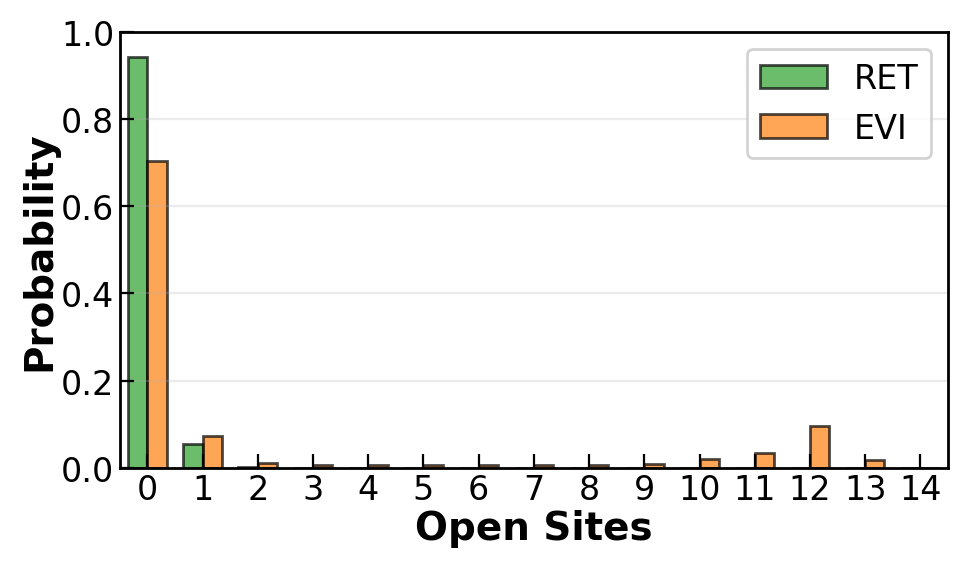

In [81]:
base_params = {
    'k_wrap': 1.0,
    'prot_params': { 'k_unbind': 0.1, 'k_bind': 1.0, 'p_conc': 0.04, 'cooperativity': 2.0 },
    'binding_sites': 14,
    't_max': 10000.0,
    't_steps': 10000,
    'inf_protamine': True
}

# Variants: (p_conc, cooperativity)
variants = [
    (0.0,    0.0),   # no protamine / no coop
]

storage_bound = SimulationStorage(CLUSTER_OUTPUT_DIR / f"exactpoint_boundpromoter_regions_breath/paramexp_{base_params['k_wrap']}")
storage_unbound = SimulationStorage(CLUSTER_OUTPUT_DIR / f"exactpoint_unboundpromoter_regions_breath/paramexp_{base_params['k_wrap']}")

results_variants = []
for p_c, coop in variants:
    try:
        # res = survival_for_variant(storage_bound, storage_unbound, base_params, p_c, coop, first=1)
        plot_nucbound_protbound(storage_bound, storage_unbound, base_params, p_c, coop, first=1, plot_protamine=False, save_path=thesis_dir / "Chapter_HistProt/SSA")
    #     results_variants.append(res)
    #     print(f"Done: p_conc={p_c}, coop={coop}, AUC_metric={res['AUC_metric']:.4g}")
    except ValueError as e:
        print(f"Skip (p_conc={p_c}, coop={coop}): {e}")


## **With Protamines**

In [13]:
# ...existing code...

# ---- Helper to compute survival for a given (p_conc, cooperativity) pair ----
def survival_for_variant(storage_bound: SimulationStorage,
                         storage_unbound: SimulationStorage,
                         base_params: dict,
                         p_conc: float,
                         coop: float,
                         first: int = 1,
                         bp_window = (-2000, 2000)):
    """Return dict with times, bound/unbound survival, ratio, AUCs."""
    params = base_params.copy()
    params_pp = params["prot_params"].copy()
    params_pp["p_conc"] = p_conc
    params_pp["cooperativity"] = coop
    params["prot_params"] = params_pp  # updated nested dict

    # Lazy frames
    bound_lz = read_tsv_from_storage(storage_bound, first=first, **params)
    unbound_lz = read_tsv_from_storage(storage_unbound, first=first, **params)

    times_b, S_b, AUC_b = compute_survival_from_tsv_polars(bound_lz, params['t_max'], params['t_steps'], bp_window)
    times_u, S_u, AUC_u = compute_survival_from_tsv_polars(unbound_lz, params['t_max'], params['t_steps'], bp_window)

    print(S_b)
    print(S_u)

    # Ensure identical time grids
    assert np.allclose(times_b, times_u)
    ratio = np.divide(S_u, S_b, out=np.full_like(S_b, np.nan), where=(S_b > 0))

    auc_ratio = (AUC_b - AUC_u) / (AUC_b + AUC_u) if (AUC_b + AUC_u) != 0 else np.nan

    print("Min S_b:", S_b.min(), "Min S_u:", S_u.min(), "Min ratio:", np.nanmin(ratio))
    print("auc_ratio:", auc_ratio)

    return dict(p_conc=p_conc,
                coop=coop,
                times=times_b,
                S_bound=S_b,
                S_unbound=S_u,
                ratio=ratio,
                AUC_bound=AUC_b,
                AUC_unbound=AUC_u,
                AUC_metric=auc_ratio)

# ---- Define variants (edit as needed) ----
base_params = {
    'k_wrap': 1.0,
    'prot_params': { 'k_unbind': 0.1, 'k_bind': 1.0, 'p_conc': 0.04, 'cooperativity': 2.0 },
    'binding_sites': 14,
    't_max': 10000.0,
    't_steps': 10000,
    'inf_protamine': True
}

# Variants: (p_conc, cooperativity)
variants = [
    (0.0,    0.0),   # no protamine / no coop
    (0.4,   0.0),   # baseline
    (0.4,   2.0),   # higher cooperativity
    # add more tuples if needed
]

storage_bound = SimulationStorage(CLUSTER_OUTPUT_DIR / f"exactpoint_boundpromoter_regions_breath/paramexp_{base_params['k_wrap']}")
storage_unbound = SimulationStorage(CLUSTER_OUTPUT_DIR / f"exactpoint_unboundpromoter_regions_breath/paramexp_{base_params['k_wrap']}")

results_variants = []
for p_c, coop in variants:
    try:
        res = survival_for_variant(storage_bound, storage_unbound, base_params, p_c, coop, first=1)
        plot_nucbound_protbound(storage_bound, storage_unbound, base_params, p_c, coop, first=1)
        results_variants.append(res)
        print(f"Done: p_conc={p_c}, coop={coop}, AUC_metric={res['AUC_metric']:.4g}")
    except ValueError as e:
        print(f"Skip (p_conc={p_c}, coop={coop}): {e}")

# ---- Plot survival probability ratios (Bound / Unbound) ----
plt.figure(figsize=(8,5))
for res in results_variants:
    plt.plot(res['times'], res['ratio'],
             label=f"p={res['p_conc']}, coop={res['coop']} (AUC m={res['AUC_metric']:.2g})",
             linewidth=1.4)
plt.xlabel("Time")
plt.ylabel("Survival Ratio S_unbound / S_bound")
plt.title("Survival Probability Ratio vs Time")
plt.ylim(bottom=0)
plt.grid(alpha=0.3)
plt.legend(framealpha=0.85)
plt.tight_layout()
plt.show()

# ---- (Optional) Overlay raw survival curves for each variant (small multiples) ----
n = len(results_variants)
fig, axes = plt.subplots(1, n, figsize=(4*n,4), sharey=True)
if n == 1: axes = [axes]
for ax, res in zip(axes, results_variants):
    ax.plot(res['times'], res['S_bound'], color='green', label='Bound', lw=1.3)
    ax.plot(res['times'], res['S_unbound'], color='orange', ls='--', label='Unbound', lw=1.3)
    ax.set_title(f"p={res['p_conc']}, coop={res['coop']}")
    ax.set_xlabel("Time")
    ax.grid(alpha=0.25)
    ax.set_ylim(0, 1.05)

axes[0].set_ylabel("Survival Probability S(t)")
axes[0].legend()
plt.tight_layout()
plt.show()

# ---- (Optional) Tabulate summary metrics ----
summary_rows = [
    dict(p_conc=r['p_conc'], coop=r['coop'],
         AUC_bound=r['AUC_bound'], AUC_unbound=r['AUC_unbound'],
         AUC_metric=r['AUC_metric'])
    for r in results_variants
]
summary_df = pd.DataFrame(summary_rows)
display(summary_df)
# ...existing code...

Negative detach_time: 16009/16009 (100.00%)
[1. 1. 1. ... 1. 1. 1.]
Negative detach_time: 10190/10190 (100.00%)
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
Min S_b: 1.0 Min S_u: 1.0 Min ratio: 1.0
auc_ratio: 0.0


NameError: name 'plot_nucbound_protbound' is not defined

Negative detach_time: 16009/16009 (100.00%)
[1. 1. 1. ... 1. 1. 1.]
Negative detach_time: 10190/10190 (100.00%)
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
Min S_b: 1.0 Min S_u: 1.0 Min ratio: 1.0
auc_ratio: 0.0
Negative detach_time: 16009/16009 (100.00%)
[1. 1. 1. ... 1. 1. 1.]
Negative detach_time: 10190/10190 (100.00%)
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
Min S_b: 1.0 Min S_u: 1.0 Min ratio: 1.0
auc_ratio: 0.0
Negative detach_time: 16009/16009 (100.00%)
[1. 1. 1. ... 1. 1. 1.]
Negative detach_time: 10190/10190 (100.00%)
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
Min S_b: 1.0 Min S_u: 1.0 Min ratio: 1.0
auc_ratio: 0.0
Negative detach_time: 16009/16009 (100.00%)
[1. 1. 1. ... 1. 1. 1.]
Negative detach_time: 10190/10190 (100.00%)
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
Min S_b: 1.0 Min S_u: 1.0 Min ratio: 1.0
auc_ratio: 0.0
Negative detach_time: 16009/16009 (100.0

,state,coop,EC50,Hill_n,slope_dPdc_at_EC50
0,EVI,0.0,0.376450,1.100244,0.730671
1,EVI,0.5,0.297288,1.111313,0.934543
2,EVI,1.0,0.237219,1.057589,1.114572
3,EVI,2.0,0.131713,0.967127,1.835675
4,EVI,3.0,0.098107,0.897941,2.288159
5,EVI,3.5,0.088835,0.844754,2.377305
6,EVI,4.0,0.084722,0.815195,2.405490
7,EVI,5.0,0.079302,0.761969,2.402106
8,EVI,6.0,0.072594,0.699564,2.409170
9,EVI,8.0,0.072094,0.695344,2.411239


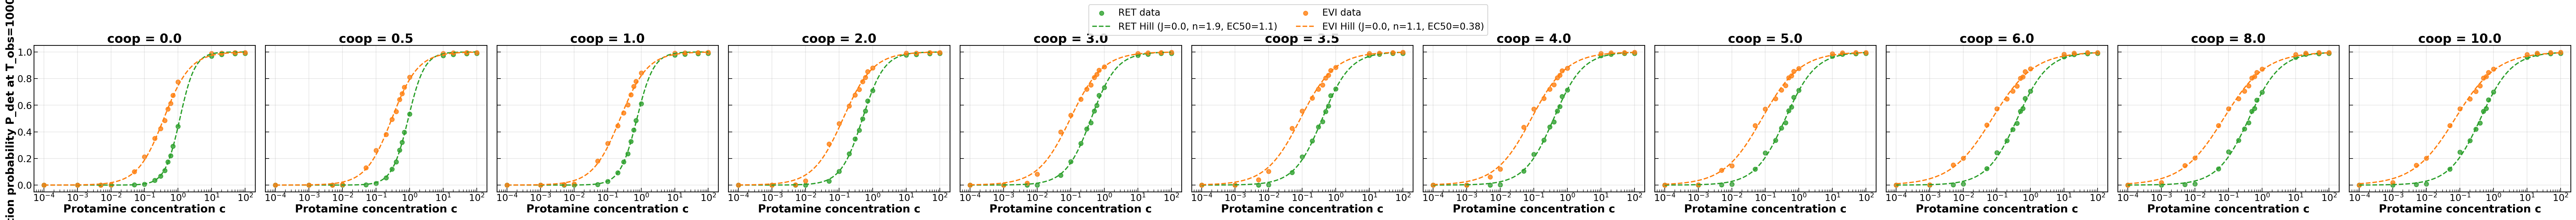

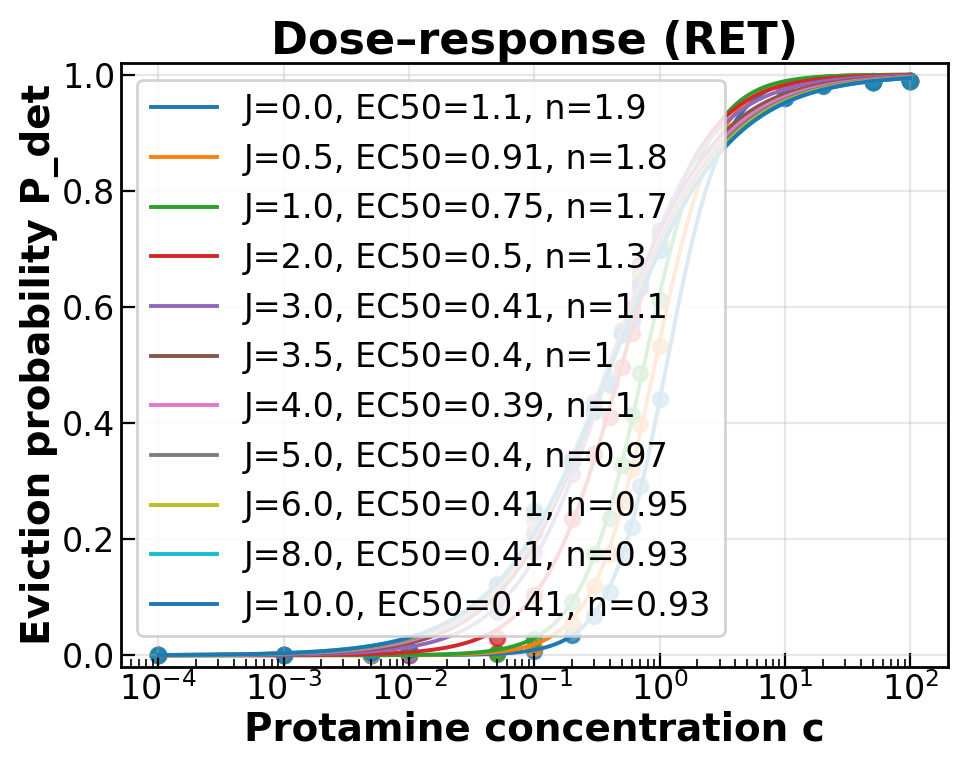

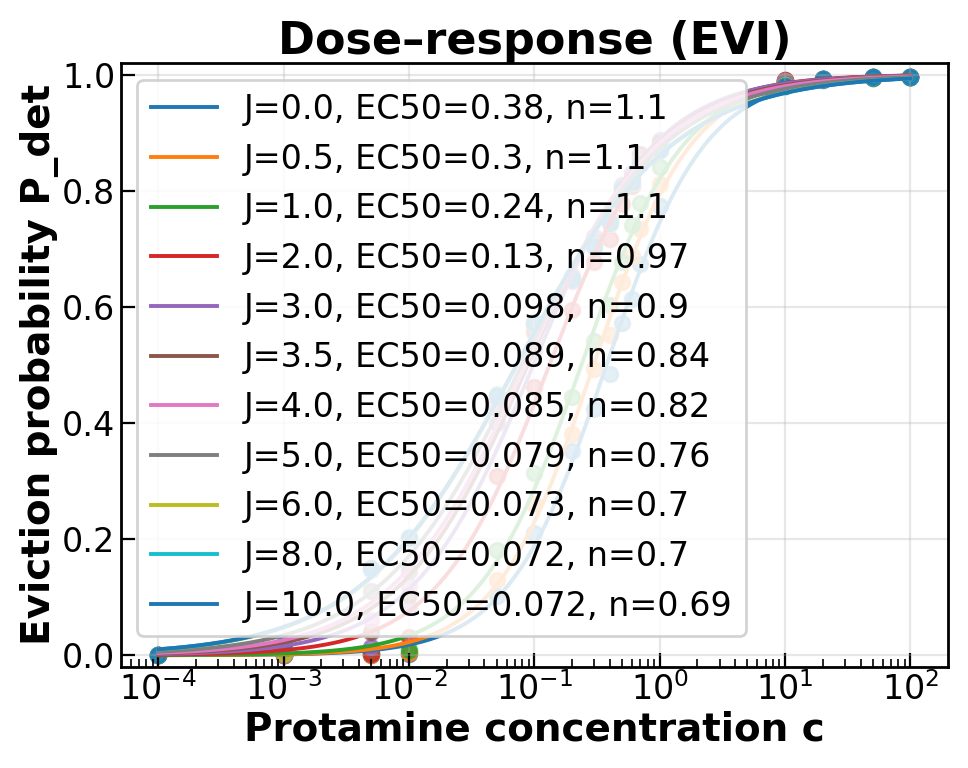

In [14]:
# ...existing code...

from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def hill_fn(c, EC50, n):
    """Simple 2‑parameter Hill (baseline 0, max 1)."""
    return (c**n) / (EC50**n + c**n)

def fit_hill(c_vals, p_vals):
    """Fit Hill curve; returns (EC50, n) or (np.nan, np.nan) on failure."""
    try:
        # Initial guesses: EC50 ~ geometric mid; n ~ 1
        c_pos = c_vals[c_vals > 0]
        if len(c_pos) < 3:
            return np.nan, np.nan
        p0 = [np.median(c_pos), 1.0]
        bounds = ([min(c_pos)*1e-3, 0.1], [max(c_pos)*1e3, 10.0])
        popt, _ = curve_fit(hill_fn, c_pos, p_vals[c_vals > 0], p0=p0, bounds=bounds, maxfev=10000)
        return popt
    except Exception:
        return np.nan, np.nan

def extract_pdet_at_time(times, S, T_obs):
    """Eviction probability at observation time."""
    if T_obs is None:
        T_obs = times[-1]
    idx = min(len(times)-1, np.searchsorted(times, T_obs))
    S_t = S[idx]
    return 1.0 - S_t, S_t

def collect_dose_response(storage_bound, storage_unbound, base_params,
                          p_conc_values, coop_values, T_obs=None, first=1, bp_window=(-2000,2000)):
    rows = []
    for c in p_conc_values:
        # Only allow non‑zero cooperativity if concentration > 0
        allowed_coops = [0.0] if c == 0 else coop_values
        for coop in allowed_coops:
            try:
                res = survival_for_variant(storage_bound, storage_unbound, base_params, c, coop,
                                           first=first, bp_window=bp_window)
            except ValueError as e:
                print(f"Skip c={c}, coop={coop}: {e}")
                continue
            Pdet_bound, Sbound = extract_pdet_at_time(res['times'], res['S_bound'], T_obs)
            Pdet_unbound, Sunbound = extract_pdet_at_time(res['times'], res['S_unbound'], T_obs)
            rows.append(dict(state="RET",  p_conc=c, coop=coop, P_det=Pdet_bound,  S=Sbound,  T_obs=T_obs))
            rows.append(dict(state="EVI",  p_conc=c, coop=coop, P_det=Pdet_unbound, S=Sunbound, T_obs=T_obs))
    return pd.DataFrame(rows)

# ---- Parameter sweep (choose richer concentration grid for fitting) ----
p_conc_values = [0.0,  0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 1.0, 10, 20, 50, 100]  # extend as needed
coop_values = [0.0, 0.5, 1.0, 2.0, 3.0, 3.5, 4.0, 5.0, 6.0, 8.0, 10.0]  # extend as needed
# p_conc_values = [0.0, 0.1, 1.0, 2.0, 3.0, 4.0, 5.0]  # extend as needed
# coop_values = [0.0, 0.5, 1.0, 2.0, 3.0, 4.0]  # extend as needed
# T_obs = base_params['t_max']  # final observation time
T_obs = 10000  # final observation time

dose_df = collect_dose_response(storage_bound, storage_unbound, base_params,
                                p_conc_values, coop_values, T_obs=T_obs, first=1)

# ---- Fit Hill per (state, coop) ----
fit_rows = []
for (state, coop), sub in dose_df.groupby(['state','coop']):
    c = sub['p_conc'].to_numpy()
    p = sub['P_det'].to_numpy()
    # Skip zero for fit
    mask = c > 0
    EC50, nH = fit_hill(c[mask], p[mask])
    if np.isfinite(EC50) and np.isfinite(nH):
        slope_at_EC50 = nH / (4 * EC50)          # dP/dc at EC50
    else:
        slope_at_EC50 = np.nan
    fit_rows.append(dict(state=state, coop=coop, EC50=EC50, Hill_n=nH, slope_dPdc_at_EC50=slope_at_EC50))
fits_df = pd.DataFrame(fit_rows)
display(fits_df)

# ---- Plot: P_det vs p_conc (log x) with Hill fits ----
fig, axes = plt.subplots(1, len(coop_values), figsize=(4.2*len(coop_values), 4), sharey=True)
if len(coop_values) == 1:
    axes = [axes]

colors = {"RET":"tab:green", "EVI":"tab:orange"}

for ax, coop in zip(axes, coop_values):
    for state in ["RET","EVI"]:
        sub = dose_df[(dose_df.coop==coop) & (dose_df.state==state)]
        ax.scatter(sub.p_conc, sub.P_det, color=colors[state], label=f"{state} data" if coop==coop_values[0] else None, s=30, alpha=0.8)
        # Overlay fit
        fit_row = fits_df[(fits_df.state==state) & (fits_df.coop==coop)]
        if not fit_row.empty and np.isfinite(fit_row.EC50.values[0]):
            EC50 = fit_row.EC50.values[0]; nH = fit_row.Hill_n.values[0]
            c_fit = np.logspace(np.log10(max(min(sub.p_conc[sub.p_conc>0]), 1e-4)),
                                np.log10(max(sub.p_conc)), 300)
            ax.plot(c_fit, hill_fn(c_fit, EC50, nH), color=colors[state], lw=1.6,
                    ls="--", label=f"{state} Hill (J={coop}, n={nH:.2g}, EC50={EC50:.2g})")
    ax.set_xscale('log')
    ax.set_xlabel("Protamine concentration c")
    ax.set_title(f"coop = {coop}")
    ax.grid(alpha=0.3)

axes[0].set_ylabel(f"Eviction probability P_det at T_obs={T_obs:g}")
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, framealpha=0.85)
plt.tight_layout(rect=(0,0,1,0.90))
plt.show()

# ---- (Optional) Combined plot per state (overlay coop curves) ----
for state in ["RET","EVI"]:
    plt.figure(figsize=(5,4))
    for coop in coop_values:
        sub = dose_df[(dose_df.state==state) & (dose_df.coop==coop)]
        plt.scatter(sub.p_conc, sub.P_det, s=28, alpha=0.75)
        row = fits_df[(fits_df.state==state) & (fits_df.coop==coop)]
        if not row.empty and np.isfinite(row.EC50.values[0]):
            EC50 = row.EC50.values[0]; nH = row.Hill_n.values[0]
            c_fit = np.logspace(np.log10(max(min(sub.p_conc[sub.p_conc>0]),1e-4)),
                                np.log10(max(sub.p_conc)), 300)
            plt.plot(c_fit, hill_fn(c_fit, EC50, nH), lw=1.4,
                     label=f"J={coop}, EC50={EC50:.2g}, n={nH:.2g}")
    plt.xscale('log')
    plt.ylim(-0.02, 1.02)
    plt.xlabel("Protamine concentration c")
    plt.ylabel("Eviction probability P_det")
    plt.title(f"Dose–response ({state})")
    plt.grid(alpha=0.3)
    plt.legend(framealpha=0.85)
    plt.tight_layout()
    plt.show()

# ...existing code...

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator
from matplotlib.colors import Normalize
import matplotlib.cm as cm
def plot_family_over_J(dose_df, state, coop_values=None, ax=None, title=None):
    """
    Smooth P_det(c) for each J using PCHIP (no parametric assumptions).
    """
    sub_all = dose_df[dose_df.state == state]
    if coop_values is None:
        coop_values = np.sort(sub_all.coop.unique())

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))
    else:
        fig = ax.figure

    # color map by J
    norm = Normalize(vmin=min(coop_values), vmax=max(coop_values))
    cmap = cm.get_cmap('viridis')

    for J in coop_values:
        sub = sub_all[sub_all.coop == J].sort_values('p_conc')
        c = sub.p_conc.values
        p = sub.P_det.values
        m = c > 0
        if m.sum() < 2:
            continue
        x = np.log10(c[m]); y = np.clip(p[m], 0, 1)
        # enforce nondecreasing
        y = np.maximum.accumulate(y)
        f = PchipInterpolator(x, y, extrapolate=False)
        xg = np.linspace(x.min(), x.max(), 300)
        yg = f(xg)
        ax.plot(10**xg, yg, color=cmap(norm(J)), lw=2, label=f"J={J}")
        ax.scatter(c[m], y, color=cmap(norm(J)), s=18, alpha=0.7)

    ax.set_xscale('log')
    ax.set_ylim(-0.02, 1.02)
    ax.set_xlabel("Protamine concentration $c$ (µM)")
    ax.set_ylabel("$P_{\\rm det}$ at $T_{\\rm obs}$")
    ax.set_title(title or f"{state}: family of $J$")
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    cbar = fig.colorbar(sm, ax=ax, pad=0.01)
    cbar.set_label("$J$ ($k_BT$)")
    ax.grid(alpha=0.3)
    return ax

/tmp/ipykernel_3523548/1721458034.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


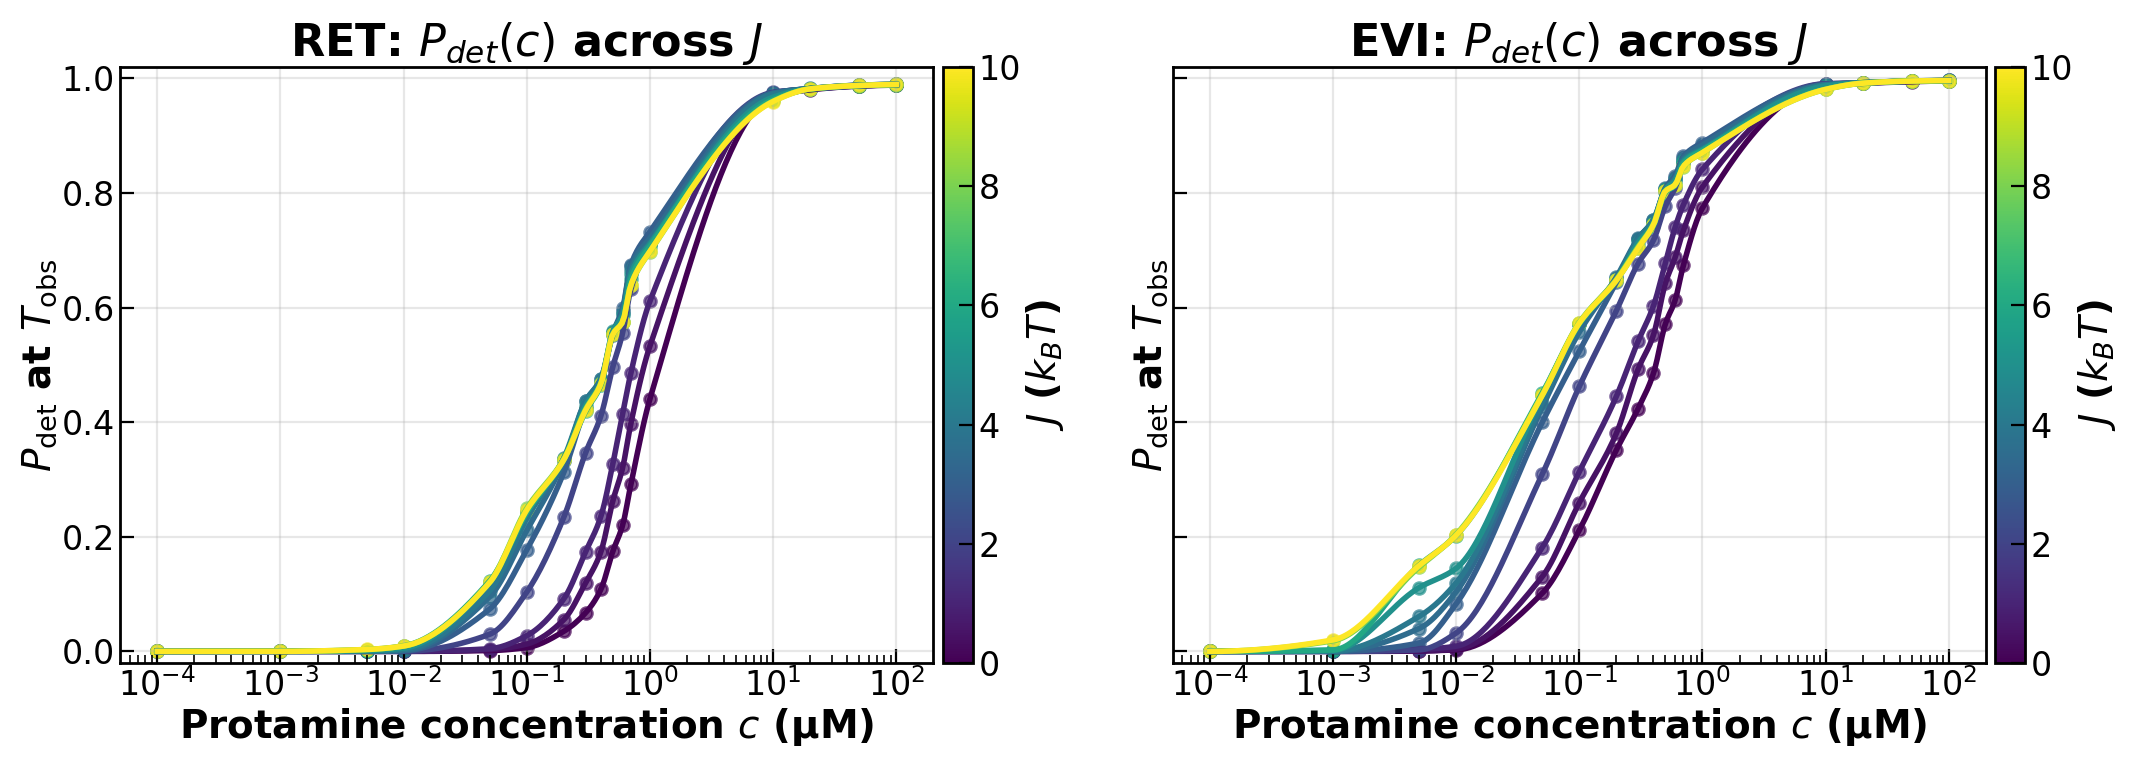

In [16]:
# Family of J curves
fig, axes = plt.subplots(1, 2, figsize=(11,4), sharey=True)
plot_family_over_J(dose_df, "RET", ax=axes[0], title="RET: $P_{det}(c)$ across $J$")
plot_family_over_J(dose_df, "EVI", ax=axes[1], title="EVI: $P_{det}(c)$ across $J$")
plt.tight_layout(); plt.show()

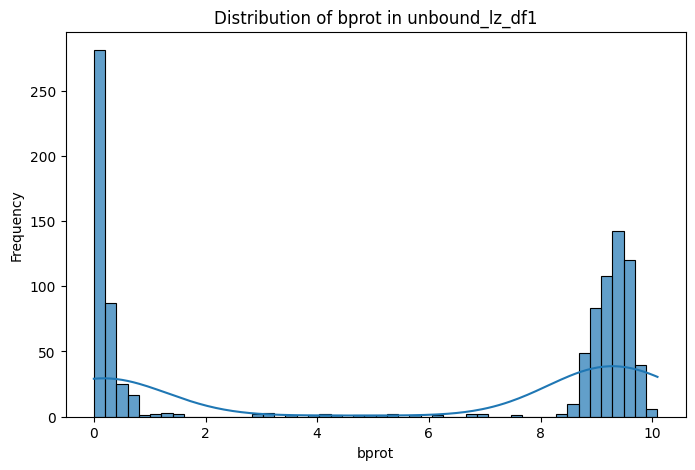

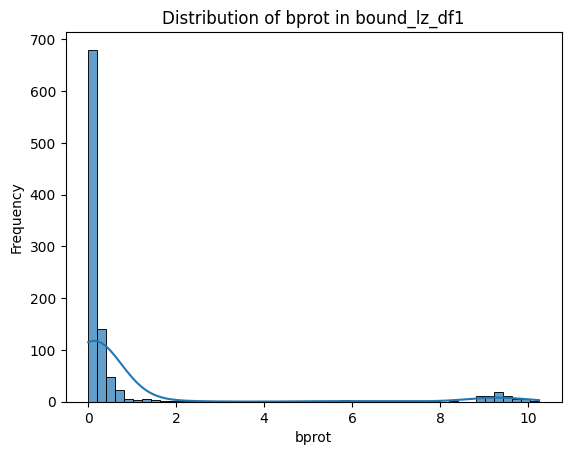

In [48]:
# ---- Imports ----
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, Tuple, List, Optional

from scipy.optimize import curve_fit
from scipy.interpolate import PchipInterpolator

# ---- Assumed available in your env ----
# from your_code import SimulationStorage, read_tsv_from_storage, compute_survival_from_tsv_polars

# ===============================
# Core helpers
# ===============================

@dataclass
class SurvivalResult:
    c: float
    J: float
    times: np.ndarray
    S_RET: np.ndarray
    S_EVI: np.ndarray

    @property
    def P_RET(self):  # eviction probability by T_obs (computed later via helper)
        return None

    @property
    def P_EVI(self):
        return None

def survival_for_variant(storage_ret, storage_evi, base_params: dict,
                         c: float, J: float, first: Optional[int]=None,
                         bp_window: Tuple[int,int]=(-2000,2000)) -> SurvivalResult:
    """Compute survival curves S(t) for RET and EVI at (c,J)."""
    params = base_params.copy()
    pp = params["prot_params"].copy()
    pp["p_conc"] = c
    pp["cooperativity"] = J
    params["prot_params"] = pp

    ret_lz = read_tsv_from_storage(storage_ret, first=first, **params)
    evi_lz = read_tsv_from_storage(storage_evi, first=first, **params)

    t_ret, S_ret, _ = compute_survival_from_tsv_polars(ret_lz, params["t_max"], params["t_steps"], bp_window)
    t_evi, S_evi, _ = compute_survival_from_tsv_polars(evi_lz, params["t_max"], params["t_steps"], bp_window)
    assert np.allclose(t_ret, t_evi)
    return SurvivalResult(c, J, t_ret, S_ret, S_evi)

def p_det_at_T(times: np.ndarray, S: np.ndarray, T_obs: Optional[float]) -> float:
    """Eviction probability at observation time."""
    if T_obs is None:
        T_obs = times[-1]
    idx = min(len(times)-1, int(np.searchsorted(times, T_obs)))
    return 1.0 - float(S[idx])

def T50_from_S(times: np.ndarray, S: np.ndarray) -> Optional[float]:
    """Median detachment time where S(t)=0.5; returns None if not reached."""
    if S.min() > 0.5:
        return None
    # monotone-ish; use PCHIP in time for smooth crossing
    f = PchipInterpolator(times, S)
    # root of S(t) - 0.5
    lo, hi = times[0], times[-1]
    # bracket by scanning
    mask = S <= 0.5
    i = np.argmax(mask)  # first time it dips below
    if i == 0:
        return times[0]
    # bisection on [times[i-1], times[i]]
    a, b = times[i-1], times[i]
    for _ in range(40):
        m = 0.5*(a+b)
        if f(m) - 0.5 > 0:
            a = m
        else:
            b = m
    return 0.5*(a+b)

# ---- EC50 calculations ----

def hill4(c, E50, n, Amax, Amin):
    """4-parameter Hill: y = Amin + (Amax-Amin)*c^n/(E50^n + c^n)"""
    c = np.asarray(c, dtype=float)
    return Amin + (Amax - Amin) * (c**n) / (E50**n + c**n)

def fit_hill4(c_vals, p_vals) -> Tuple[float,float,float,float]:
    """Return (EC50, n, Amax, Amin); np.nan on failure."""
    c = np.asarray(c_vals, float)
    y = np.asarray(p_vals, float)
    mask = (c > 0) & np.isfinite(y)
    c, y = c[mask], y[mask]
    if len(c) < 4:
        return (np.nan,)*4
    # Initial guesses
    Amin0 = max(0.0, min(y))
    Amax0 = min(1.0, max(y))
    E500 = 10**np.mean(np.log10([max(min(c),1e-6), max(c)]))
    n0 = 1.0
    p0 = [E500, n0, Amax0, Amin0]
    bounds = ([min(c)/10, 0.1, 0.0, 0.0],
              [max(c)*10, 10.0, 1.0, 0.5])
    try:
        popt, _ = curve_fit(hill4, c, y, p0=p0, bounds=bounds, maxfev=20000)
        return tuple(popt)  # EC50, n, Amax, Amin
    except Exception:
        return (np.nan,)*4

def ec50_modelfree(c_vals, p_vals) -> float:
    """EC50 via half dynamic range, monotone PCHIP in log10(c).
       Returns np.nan if not bracketed."""
    c = np.asarray(c_vals, float)
    p = np.asarray(p_vals, float)
    mask = (c > 0) & np.isfinite(p)
    c, p = c[mask], p[mask]
    if len(c) < 3:
        return np.nan
    order = np.argsort(c)
    c, p = c[order], p[order]
    pmin, pmax = float(np.min(p)), float(np.max(p))
    if pmax <= pmin + 1e-6:
        return np.nan
    target = pmin + 0.5*(pmax - pmin)
    # enforce monotonic non-decreasing by cumulative maximum
    p_mono = np.maximum.accumulate(p)
    # interpolate in log10(c) for smoother mid region
    x = np.log10(c)
    f = PchipInterpolator(x, p_mono)
    # root-find for f(x)=target within observed range
    if (p_mono[0] > target) or (p_mono[-1] < target):
        return np.nan
    # bisection
    a, b = x[0], x[-1]
    for _ in range(60):
        m = 0.5*(a+b)
        if f(m) >= target:
            b = m
        else:
            a = m
    return 10**(0.5*(a+b))

# ===============================
# Orchestrate the minimal analysis
# ===============================

def scan_concentrations(storage_ret, storage_evi, base_params,
                        conc_grid: List[float], J: float,
                        T_obs: Optional[float]=None, first: Optional[int]=None):
    rows = []
    results = []


    for c in conc_grid:


        # --- skip impossible/unsimulated combos: concentration 0 with non-zero cooperativity
        if c == 0.0 and J != 0.0:
            # optionally log for debugging
            print(f"Skipping c=0.0 for J={J} (no simulations expected).")
            continue

        try:
            res = survival_for_variant(storage_ret, storage_evi, base_params, c, J, first=first)
        except ValueError as e:
            # missing simulation files for this parameter set: report and continue
            print(f"Skipping (c={c}, J={J}): {e}")
            continue
        P_ret = p_det_at_T(res.times, res.S_RET, T_obs)
        P_evi = p_det_at_T(res.times, res.S_EVI, T_obs)
        T50_ret = T50_from_S(res.times, res.S_RET)
        T50_evi = T50_from_S(res.times, res.S_EVI)
        rows += [
            dict(cohort="RET", c=c, J=J, P=P_ret, T50=T50_ret),
            dict(cohort="EVI", c=c, J=J, P=P_evi, T50=T50_evi),
        ]
        results.append((c, res))
    return pd.DataFrame(rows), results

def choose_c_star(df_Jstar: pd.DataFrame) -> float:
    """Pick smallest c where EVI~0.5 and RET<=0.2; if not found, pick c maximizing P_EVI-P_RET."""
    wide = df_Jstar.pivot(index="c", columns="cohort", values="P").sort_index()
    # Criterion
    mask = (wide["EVI"] >= 0.6) & (wide["RET"] <= 0.3)
    cand = wide.index[mask]
    if len(cand) > 0:
        return float(cand.min())
    # fallback: argmax separation
    sep = wide["EVI"] - wide["RET"]
    return float(sep.index[np.argmax(sep.values)])

#

def run_minimal(storage_ret, storage_evi, base_params,
                conc_grid, J_star: float, T_obs: float, first: Optional[int]=None):
    # Scan J=0 and J=J*
    df0, _   = scan_concentrations(storage_ret, storage_evi, base_params, conc_grid, J=0.0,    T_obs=T_obs, first=first)
    dfJ, res = scan_concentrations(storage_ret, storage_evi, base_params, conc_grid, J=J_star, T_obs=T_obs, first=first)

    # Pick c* (from J* data)
    c_star = choose_c_star(dfJ)

    # Compute EC50 (both model-free and Hill-4) and T50 at c*
    out_rows = []
    for cohort in ["EVI","RET"]:
        sub0 = df0[df0.cohort==cohort].sort_values("c")
        subJ = dfJ[dfJ.cohort==cohort].sort_values("c")

        # EC50 (model-free)
        EC50_0_mf = ec50_modelfree(sub0.c.values, sub0.P.values)
        EC50_J_mf = ec50_modelfree(subJ.c.values, subJ.P.values)

        # EC50 (Hill-4 fit)
        EC50_0, n0, Amax0, Amin0 = fit_hill4(sub0.c.values, sub0.P.values)
        EC50_J, nJ, AmaxJ, AminJ = fit_hill4(subJ.c.values, subJ.P.values)

        # T50 at c*
        # re-simulate once (c*=same for both panels) to read medians
        sr = survival_for_variant(storage_ret, storage_evi, base_params, c_star, J_star, first=first)
        T50 = T50_from_S(sr.times, sr.S_EVI if cohort=="EVI" else sr.S_RET)
        P_at_cstar = p_det_at_T(sr.times, sr.S_EVI if cohort=="EVI" else sr.S_RET, T_obs)

        out_rows.append(dict(
            cohort=cohort, J_star=J_star, c_star=c_star, P_at_cstar=P_at_cstar,
            EC50_mfree_J0=EC50_0_mf, EC50_mfree_Jstar=EC50_J_mf,
            EC50_hill_J0=EC50_0, nH_J0=n0, EC50_hill_Jstar=EC50_J, nH_Jstar=nJ,
            T50_at_cstar=T50
        ))

    metrics = pd.DataFrame(out_rows)

    # Add selectivity at c*
    wideJ = dfJ.pivot(index="c", columns="cohort", values="P").sort_index()
    if c_star in wideJ.index:
        deltaP = float(wideJ.loc[c_star, "EVI"] - wideJ.loc[c_star, "RET"])
    else:
        # nearest neighbor
        idx = int(np.argmin(np.abs(wideJ.index.values - c_star)))
        deltaP = float(wideJ.iloc[idx]["EVI"] - wideJ.iloc[idx]["RET"])
    metrics["DeltaP_at_cstar"] = deltaP

    print("\n=== Minimal metrics (report these) ===")
    display(metrics)

    return dict(metrics=metrics, df_J0=df0, df_Jstar=dfJ, c_star=c_star, J_star=J_star, survival_results=res)   

# ===============================
# Example call (edit to your paths)
# ===============================

base_params = {
    'k_wrap': 1.0,
    'prot_params': { 'k_unbind': 0.1, 'k_bind': 1.0, 'p_conc': 0.04, 'cooperativity': 2.0 },
    'binding_sites': 14,
    't_max': 10000.0,
    't_steps': 10000,
    'inf_protamine': True
}

storage_ret = SimulationStorage(CLUSTER_OUTPUT_DIR / f"exactpoint_boundpromoter_regions_breath/paramexp_{base_params['k_wrap']}")
storage_evi = SimulationStorage(CLUSTER_OUTPUT_DIR / f"exactpoint_unboundpromoter_regions_breath/paramexp_{base_params['k_wrap']}")
conc_grid = [0.0,  0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 1.0, 2.0, 5.0, 6.0, 8.0, 10, 20, 50, 100]  # extend as needed


out = run_minimal(storage_ret, storage_evi, base_params, conc_grid, J_star=2.0, T_obs=10000, first=1)
# = P_evict(J=2) - P_evict(J=0)

Negative detach_time: 16009/16009 (100.00%)
[1. 1. 1. ... 1. 1. 1.]
Negative detach_time: 10190/10190 (100.00%)
[1. 1. 1. ... 1. 1. 1.]
Negative detach_time: 16009/16009 (100.00%)
[1. 1. 1. ... 1. 1. 1.]
Negative detach_time: 10190/10190 (100.00%)
[1. 1. 1. ... 1. 1. 1.]
Negative detach_time: 16009/16009 (100.00%)
[1. 1. 1. ... 1. 1. 1.]
Negative detach_time: 10190/10190 (100.00%)
[1. 1. 1. ... 1. 1. 1.]
Negative detach_time: 16009/16009 (100.00%)
[1. 1. 1. ... 1. 1. 1.]
Negative detach_time: 10180/10190 (99.90%)
[1.         1.         1.         ... 0.99901865 0.99901865 0.99901865]
Negative detach_time: 16009/16009 (100.00%)
[1. 1. 1. ... 1. 1. 1.]
Negative detach_time: 10163/10190 (99.74%)
[1.         1.         1.         ... 0.99735034 0.99735034 0.99735034]
Negative detach_time: 15985/16009 (99.85%)
[1.         1.         1.         ... 0.99850084 0.99850084 0.99850084]
Negative detach_time: 9156/10190 (89.85%)
[1.         1.         1.         ... 0.8986261  0.8986261  0.8985279

,cohort,J_star,c_star,P_at_cstar,EC50_mfree_J0,EC50_mfree_Jstar,EC50_hill_J0,nH_J0,EC50_hill_Jstar,nH_Jstar,T50_at_cstar,DeltaP_at_cstar
0,EVI,2.0,0.2,0.594701,0.415803,0.119794,0.375970,1.115108,0.130830,0.965553,5433.543354,0.360395
1,RET,2.0,0.2,0.234306,1.169300,0.496526,1.264865,1.620530,0.495156,1.266841,NaN,0.360395


In [ ]:
#===============================
# Plotters (Minimal set)
# ===============================


# ...existing code...
def plot_survival_triptych(storage_ret, storage_evi, base_params,
                           c_star: float, J_star: float,
                           T_obs: Optional[float]=None, first: Optional[int]=None, 
                           save_path:Path=None):
    """(a) c=0,J=0; (b) c=c*,J=0; (c) c=c*,J=J*"""
    sets = [(0.0, 0.0), (c_star, 0.0), (c_star, J_star)]
    titles = [
        f"c:0 $\mathbf{{\mu M}}$, J:0 $\mathbf{{k_B T}}$",
        f"c:{c_star:g} $\mathbf{{\mu M}}$, J:0 $\mathbf{{k_B T}}$",
        f"c:{c_star:g} $\mathbf{{\mu M}}$, J:{J_star:g} $\mathbf{{k_B T}}$",
    ]
    
    import matplotlib.ticker as mtick
    from matplotlib.ticker import AutoMinorLocator, ScalarFormatter 

    fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True, gridspec_kw={'hspace': 0.3, 'wspace': 0.1})
    for ax, (c, J), ttl in zip(axes, sets, titles):
        res = survival_for_variant(storage_ret, storage_evi, base_params, c, J, first=first)
        ax.plot(res.times, res.S_RET, lw=2.2, label="RET", color="tab:green")
        ax.plot(res.times, res.S_EVI, lw=2.0, ls="--", label="EVI", color="tab:orange")

        # Observation time marker
        if T_obs:
            ax.axvline(T_obs, color="k", lw=0.8, alpha=0.4)

        # Axes labels and title
        ax.set_title(ttl)
        ax.set_xlabel("Time (s)")
        ax.grid(alpha=0.28)

        # Y limits and ticks (publication-ready)
        ax.set_ylim(0.0, 1.02)
        ax.set_xlim(0, base_params['t_max'])
        ax.yaxis.set_major_locator(mtick.MultipleLocator(0.2))
        ax.yaxis.set_minor_locator(AutoMinorLocator(5))   # 4 minor ticks between majors


        # X-axis: minor ticks and scientific notation for major tick labels
        ax.xaxis.set_minor_locator(AutoMinorLocator(5))   # places 4 minor ticks between major ticks
        sf = ScalarFormatter(usetex=True)
        sf.set_powerlimits((-3,3))   # choose when to switch to sci notation
        sf.set_scientific(True)
        ax.xaxis.set_major_formatter(sf)

        # # X-axis: ensure 4 minor ticks between majors
        # ax.xaxis.set_minor_locator(AutoMinorLocator(5))   # places 4 minor ticks between major ticks

        # Tick appearance
        ax.tick_params(which="major", width=1.0)
        ax.tick_params(which="minor", width=0.8)
        ax.tick_params(top=True, right=True)  # draw ticks on top/right for nice figures

        # faint minor grid for visual guidance
        ax.grid(which="minor", alpha=0.08)

    axes[0].set_ylabel("Survival S(t)")
    axes[0].legend(framealpha=0.85,loc='lower left')
    # fig.suptitle("Survival of the wrapped state (c in µM, J in k_B T)", y=1.02)
    plt.tight_layout()

    # show and optionally save
    plt.show()

    if save_path is not None:
        save_path.parent.mkdir(parents=True, exist_ok=True)
        for ext in ["png", "pdf", "svg"]:
            fig.savefig(save_path / f"Survival_prob.{ext}",
                        dpi=300,
                        bbox_inches='tight',
                        transparent=True)
# ...existing code...


<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_3523548/2423230405.py:14: SyntaxWarning: invalid escape sequence '\

Negative detach_time: 16009/16009 (100.00%)
[1. 1. 1. ... 1. 1. 1.]
Negative detach_time: 10190/10190 (100.00%)
[1. 1. 1. ... 1. 1. 1.]
Negative detach_time: 15446/16009 (96.48%)
[1.         1.         1.         ... 0.96483228 0.96483228 0.96483228]
Negative detach_time: 6607/10190 (64.84%)
[1.         1.         1.         ... 0.64838077 0.64838077 0.64838077]
Negative detach_time: 12258/16009 (76.57%)
[1.         1.         1.         ... 0.76575676 0.76575676 0.7656943 ]
Negative detach_time: 4130/10190 (40.53%)
[1.         1.         1.         ... 0.40529931 0.40529931 0.40529931]


/tmp/ipykernel_3523548/2423230405.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


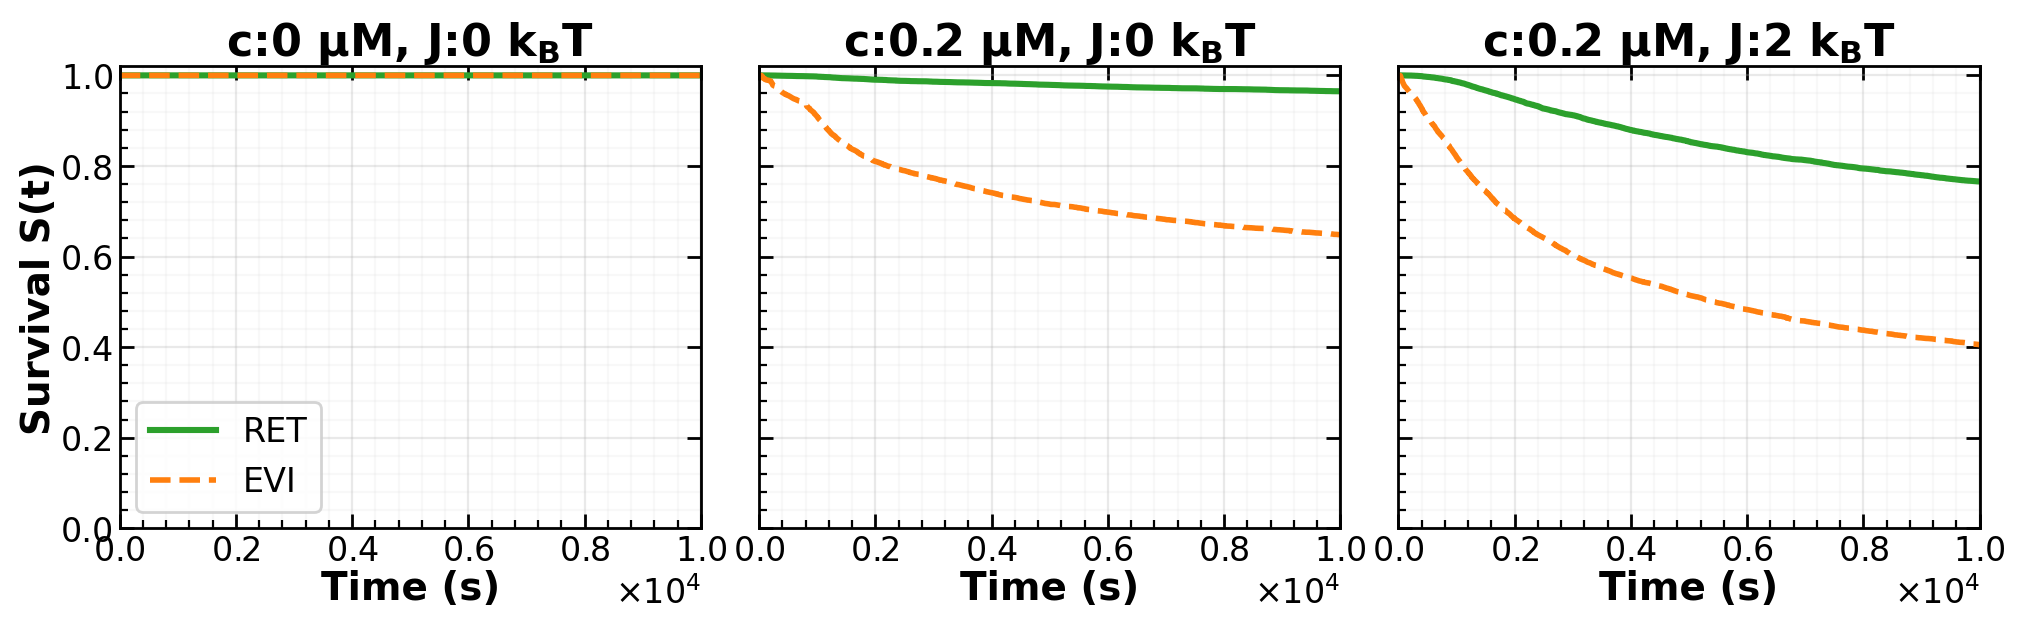

In [49]:

c_star=out['c_star']
df0=out['df_J0']
dfJ=out['df_Jstar']
J_star=out['J_star']
first=1
T_obs=10000 
# Plot 1: Survival triptych
plot_survival_triptych(storage_ret, storage_evi, base_params, c_star, J_star, T_obs=T_obs, first=first, 
                       save_path=thesis_dir / "Chapter_HistProt" / "SSA")



<>:70: SyntaxWarning: invalid escape sequence '\m'
<>:71: SyntaxWarning: invalid escape sequence '\m'
<>:70: SyntaxWarning: invalid escape sequence '\m'
<>:71: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_3523548/2108337590.py:70: SyntaxWarning: invalid escape sequence '\m'
  ax_bot.set_xlabel("Protamine concentration c ($\mathbf{{\mu M}})$")
/tmp/ipykernel_3523548/2108337590.py:71: SyntaxWarning: invalid escape sequence '\m'
  ax_bot.set_ylabel("$\mathbf{\Delta P}$")


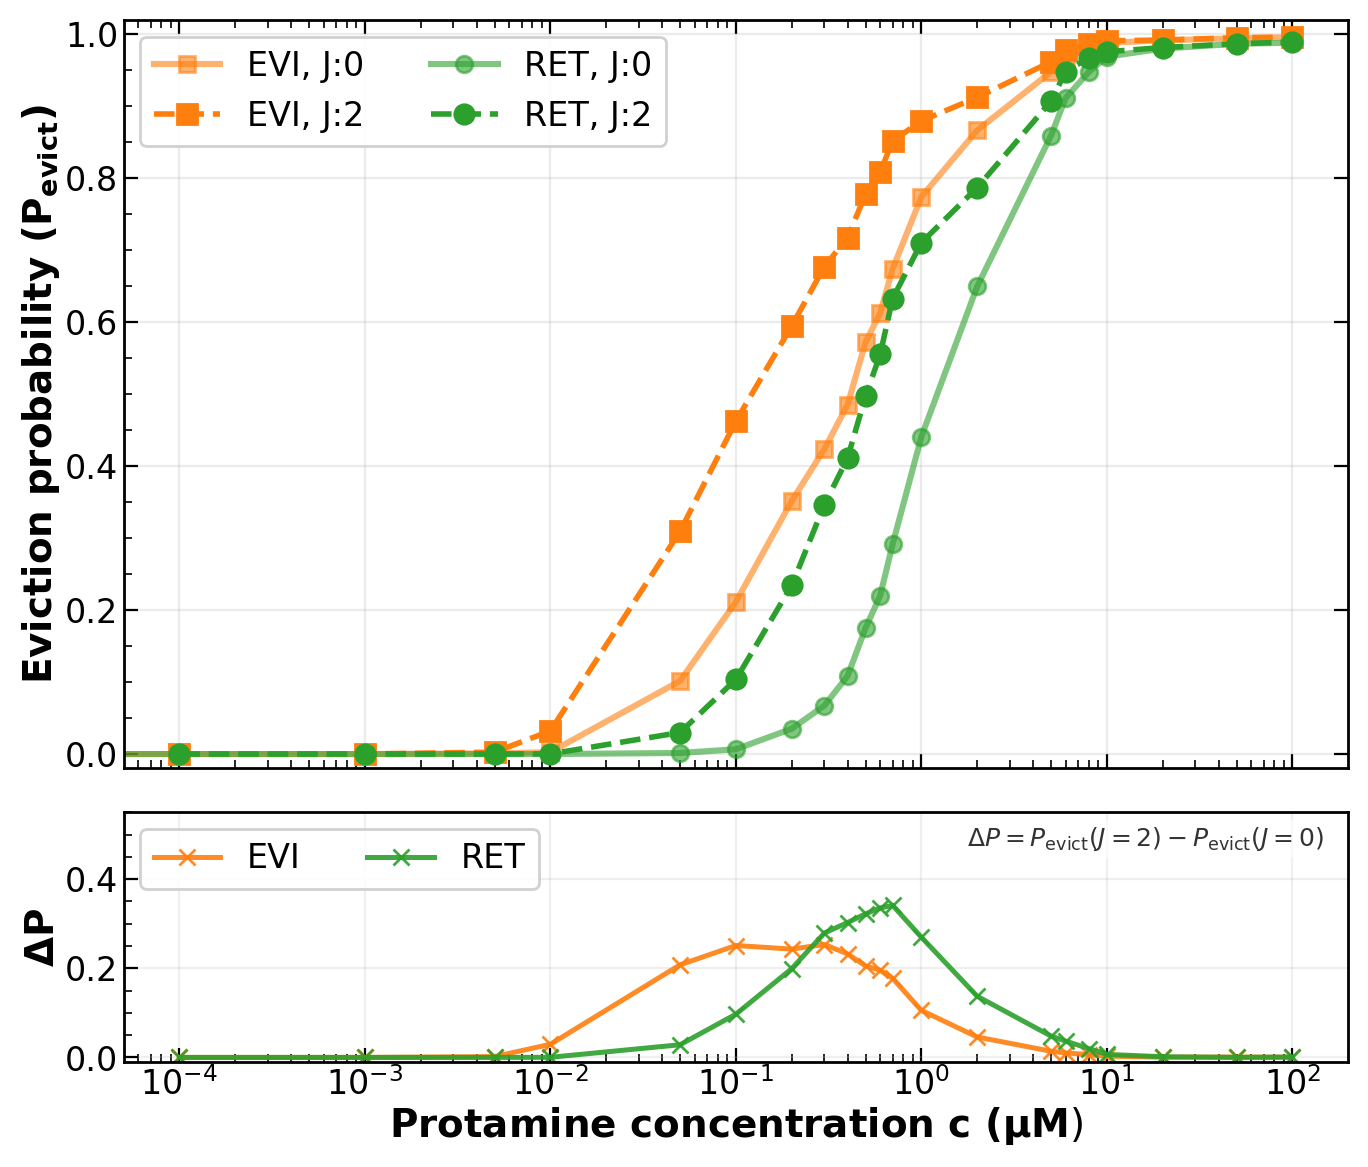

In [50]:

# def plot_dose_response_minimal(df0: pd.DataFrame, dfJ: pd.DataFrame, J_star: float, T_obs: float):
#     """Two subplots: EVI (left) and RET (right): P_evict(c) for J=0 vs J=J*."""
#     fig, axes = plt.subplots(1, 2, figsize=(9.6, 3.8), sharey=True)
#     colors = dict(EVI="tab:orange", RET="tab:green")
#     for ax, cohort in zip(axes, ["EVI", "RET"]):
#         sub0 = df0[df0.cohort==cohort].sort_values("c")
#         subJ = dfJ[dfJ.cohort==cohort].sort_values("c")
#         ax.plot(sub0.c, sub0.P, marker="o", lw=1.6, label=f"{cohort}, J=0", color=colors[cohort], alpha=0.6)
#         ax.plot(subJ.c, subJ.P, marker="o", lw=1.6, label=f"{cohort}, J={J_star:g}", color=colors[cohort])
#         ax.set_xscale("log")
#         ax.set_xlabel("Protamine concentration c (μM)")
#         ax.grid(alpha=0.3)
#         ax.set_title(cohort)
#     axes[0].set_ylabel(f"Eviction probability P_evict at T_obs={T_obs:g}s")
#     fig.legend(loc="upper center", ncol=2, framealpha=0.9)
#     fig.suptitle("Dose–response: cooperativity sharpens and left-shifts EVI")
#     plt.tight_layout(rect=(0,0,1,0.90))
#     plt.show()




def plot_dose_response_overlay(df0: pd.DataFrame, dfJ: pd.DataFrame, J_star: float, T_obs: float, save_path:Optional[Path]=None):
    """Overlay RET and EVI dose–response curves (J=0 and J=J*) and plot per-state differences."""
    from matplotlib.ticker import AutoMinorLocator
    fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(7,6), sharex=True,
                                         gridspec_kw={'height_ratios': [3, 1]})
    colors = {"RET":"tab:green", "EVI":"tab:orange"}
    markers = {"RET":"o", "EVI":"s"}

    for state in ["EVI","RET"]:
        sub0 = df0[df0.cohort==state].sort_values("c")
        subJ = dfJ[dfJ.cohort==state].sort_values("c")

        # Top: dose–response curves (J=0 solid, J=J* dashed)
        ax_top.plot(sub0.c, sub0.P, marker=markers[state], ls='-', color=colors[state],
                    alpha=0.6, linewidth=2.2, markersize=6, label=f"{state}, J:0")
        ax_top.plot(subJ.c, subJ.P, marker=markers[state], ls='--', color=colors[state],
                    alpha=1.0, linewidth=2.0, markersize=7, label=f"{state}, J:{J_star:g}")

        # Bottom: difference P(J=J*) - P(J=0)
        # merge on concentration c to align points
        merged = pd.merge(subJ[['c','P']].rename(columns={'P':'P_J'}), sub0[['c','P']].rename(columns={'P':'P_J0'}),
                          on='c', how='outer').sort_values('c')
        merged['Delta'] = merged['P_J'] - merged['P_J0']
        ax_bot.plot(merged.c, merged.Delta, marker='x', ls='-', color=colors[state],
                    alpha=0.9, linewidth=1.8, markersize=6, label=f"{state}")

    ax_top.set_xscale("log")
    ax_top.set_ylabel(r"Eviction probability ($\mathbf{P_{evict}}$)")
    ax_top.set_ylim(-0.02, 1.02)
    ax_top.grid(alpha=0.25)
    ax_top.legend(framealpha=0.9, ncol=2, loc='upper left', )


    # add minor ticks on the eviction probability (y) axis
    ax_top.yaxis.set_minor_locator(AutoMinorLocator(4))   # 4 minor intervals between majors
    ax_top.tick_params(axis='y', which='minor')  # make minor ticks visible

    # enable minor ticks on top side of the top panel
    ax_top.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax_top.tick_params(axis='x', which='both', top=True)

    # draw major ticks also on the right y-axis of the top panel
    ax_top.tick_params(axis='y', which='major', right=True)


    ax_bot.set_xscale("log")
    # ax_bot.axhline(0.0, color='k', lw=0.8, alpha=0.6)
    ax_bot.set_xlabel("Protamine concentration c ($\mathbf{{\mu M}})$")
    ax_bot.set_ylabel("$\mathbf{\Delta P}$")

    ax_bot.set_ylim(-0.01, 0.55)   # adjust if you expect larger differences
    ax_bot.grid(alpha=0.2)
    ax_bot.legend(framealpha=0.9, ncol=2, loc='upper left')
    ax_bot.yaxis.set_minor_locator(AutoMinorLocator(4))   # 4 minor intervals between majors
    ax_bot.tick_params(axis='y', which='minor')
    ax_bot.text(0.98, 0.95,
                rf"$\Delta P = P_{{\rm evict}}(J={J_star:g}) - P_{{\rm evict}}(J=0)$",
                transform=ax_bot.transAxes, ha='right', va='top', fontsize=9, fontweight='bold', color='0.2',
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.6))


    plt.tight_layout()
    plt.show()

    if save_path is not None:
        for ext in ["png", "pdf", "svg"]:
            fig.savefig(save_path / f"Dose_response.{ext}",
                        dpi=300,
                        bbox_inches='tight',
                        transparent=True)

    # return
# ...existing code...

# Plot 2: Dose–response minimal
# plot_dose_response_minimal(df0, dfJ, J_star, T_obs)
plot_dose_response_overlay(df0, dfJ, J_star, T_obs, save_path=thesis_dir / "Chapter_HistProt" / "SSA")

Negative detach_time: 16009/16009 (100.00%)
[1. 1. 1. ... 1. 1. 1.]
Negative detach_time: 10190/10190 (100.00%)
[1. 1. 1. ... 1. 1. 1.]
Negative detach_time: 16009/16009 (100.00%)
[1. 1. 1. ... 1. 1. 1.]
Negative detach_time: 10190/10190 (100.00%)
[1. 1. 1. ... 1. 1. 1.]
Negative detach_time: 16009/16009 (100.00%)
[1. 1. 1. ... 1. 1. 1.]
Negative detach_time: 10190/10190 (100.00%)
[1. 1. 1. ... 1. 1. 1.]
Negative detach_time: 16009/16009 (100.00%)
[1. 1. 1. ... 1. 1. 1.]
Negative detach_time: 10180/10190 (99.90%)
[1.         1.         1.         ... 0.99901865 0.99901865 0.99901865]
Negative detach_time: 16009/16009 (100.00%)
[1. 1. 1. ... 1. 1. 1.]
Negative detach_time: 10163/10190 (99.74%)
[1.         1.         1.         ... 0.99735034 0.99735034 0.99735034]
Negative detach_time: 15985/16009 (99.85%)
[1.         1.         1.         ... 0.99850084 0.99850084 0.99850084]
Negative detach_time: 9156/10190 (89.85%)
[1.         1.         1.         ... 0.8986261  0.8986261  0.8985279

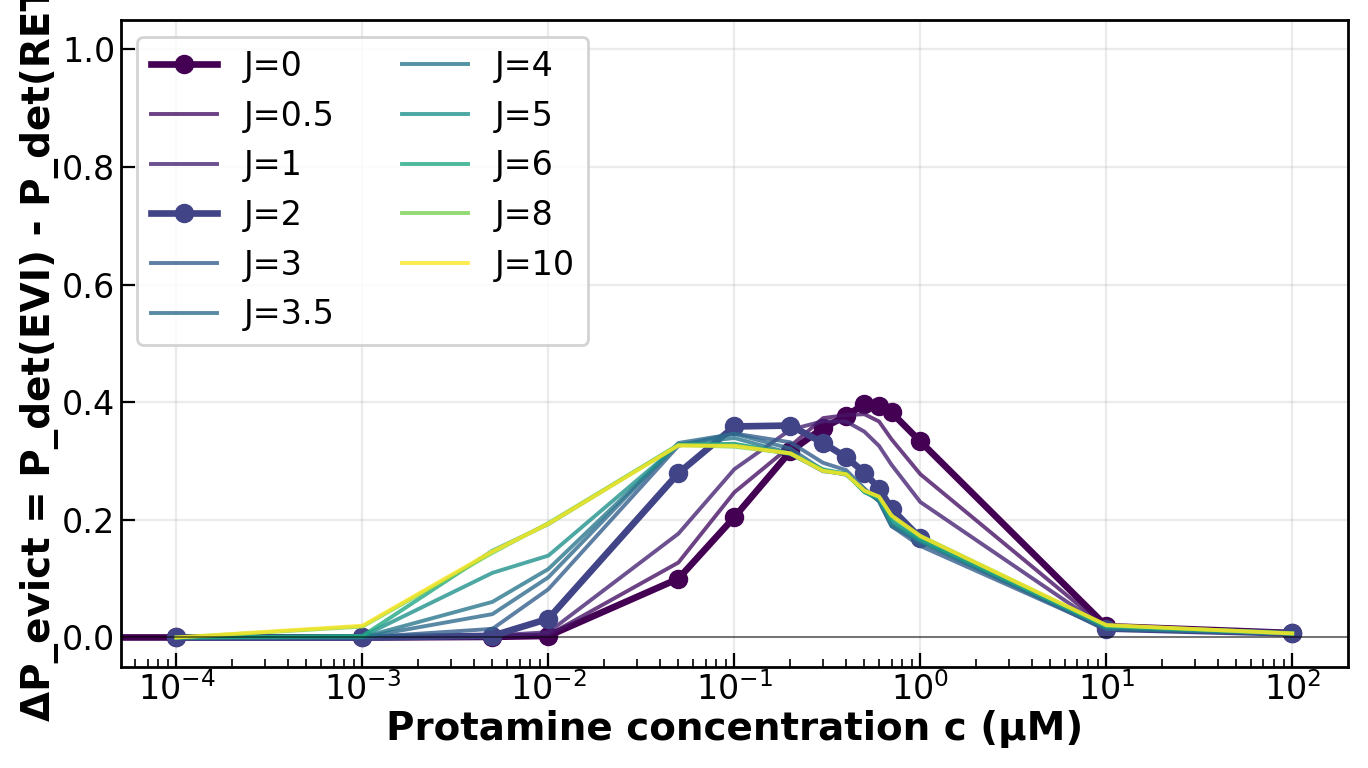

In [127]:
# ...existing code...
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Optional, Tuple
def compute_deltaP_vs_c(storage_ret, storage_evi, base_params,
                        conc_grid: List[float],
                        J_list: List[float],
                        T_obs: Optional[float]=None,
                        first: Optional[int]=1) -> pd.DataFrame:
    """
    Compute ΔP_evict(c;J) = P_det_EVI(c;J) - P_det_RET(c;J) for each J in J_list.
    Returns a tidy DataFrame with columns: c, J, P_EVI, P_RET, DeltaP.
    Calls the existing scan_concentrations() helper (which returns per-cohort P).
    """
    rows = []
    for J in J_list:
        # skip impossible combo
        dfJ, _ = scan_concentrations(storage_ret, storage_evi, base_params, conc_grid, J=J, T_obs=T_obs, first=first)
        # pivot so we have EVI / RET columns
        wide = dfJ.pivot(index="c", columns="cohort", values="P").sort_index()
        # ensure both columns exist
        if "EVI" not in wide.columns:
            wide["EVI"] = np.nan
        if "RET" not in wide.columns:
            wide["RET"] = np.nan
        for c_val, row in wide.iterrows():
            P_evi = float(row.get("EVI", np.nan))
            P_ret = float(row.get("RET", np.nan))
            rows.append(dict(c=float(c_val), J=float(J), P_EVI=P_evi, P_RET=P_ret, DeltaP=(P_evi - P_ret)))
    return pd.DataFrame(rows)


def plot_deltaP_vs_c(delta_df: pd.DataFrame,
                     J_plot_order: Optional[List[float]] = None,
                     highlight_J: Optional[List[float]] = None,
                     ax: Optional[plt.Axes] = None,
                     logx: bool = True,
                     figsize: Tuple[float,float] = (7,4)):
    """
    Plot ΔP(c;J) curves for all J in delta_df.
    - delta_df: output of compute_deltaP_vs_c (columns c,J,DeltaP)
    - J_plot_order: explicit order to plot Js (default: sorted unique)
    - highlight_J: list of Js to emphasize (plotted with thicker lines/markers)
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure

    if J_plot_order is None:
        J_plot_order = sorted(delta_df.J.unique())

    cmap = plt.get_cmap("viridis")
    norm = plt.Normalize(vmin=min(J_plot_order), vmax=max(J_plot_order))

    for J in J_plot_order:
        sub = delta_df[delta_df.J == J].sort_values("c")
        if sub.empty:
            continue
        x = sub.c.values
        y = sub.DeltaP.values
        color = cmap(norm(J))
        lw = 2.4 if (highlight_J and J in highlight_J) else 1.4
        alpha = 1.0 if (highlight_J and J in highlight_J) else 0.8
        marker = "o" if (highlight_J and J in highlight_J) else None
        if logx:
            ax.semilogx(x, y, color=color, lw=lw, alpha=alpha, marker=marker, label=f"J={J:g}")
        else:
            ax.plot(x, y, color=color, lw=lw, alpha=alpha, marker=marker, label=f"J={J:g}")

    ax.axhline(0, color="k", lw=0.6, alpha=0.6)
    ax.set_xlabel("Protamine concentration c (μM)")
    ax.set_ylabel("ΔP_evict = P_det(EVI) - P_det(RET)")
    ax.set_ylim(-0.05, 1.05)
    ax.grid(alpha=0.25)
    ax.legend(framealpha=0.85, ncol=2, loc="upper left")
    plt.tight_layout()
    return ax

# --- Usage example (cell) ---
# J_list = [0.0, 0.5, 1.0, 2.0]   # include J=0 and J>0 values you care about

storage_ret = SimulationStorage(CLUSTER_OUTPUT_DIR / f"exactpoint_boundpromoter_regions_breath/paramexp_{base_params['k_wrap']}")
storage_evi = SimulationStorage(CLUSTER_OUTPUT_DIR / f"exactpoint_unboundpromoter_regions_breath/paramexp_{base_params['k_wrap']}")
conc_grid = [0.0,  0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 1.0, 10, 100] 
J_list = [0.0, 0.5, 1.0, 2.0, 3.0, 3.5, 4.0, 5.0, 6.0, 8.0, 10.0]  # extend as needed
   # include J=0 and J>0 values you care about
delta_df = compute_deltaP_vs_c(storage_ret, storage_evi, base_params,
                               conc_grid, J_list, T_obs=10000, first=1)
ax = plot_deltaP_vs_c(delta_df, highlight_J=[0.0, 2.0])
plt.show()
# ...existing code...

In [110]:
filtered = bound_df.filter(pl.col("cs_total") > 10)
print(filtered)

shape: (623, 5)
┌────────────────────┬───────┬──────────┬────────┬─────────────┐
│ id                 ┆ subid ┆ cs_total ┆ bprot  ┆ detach_time │
│ ---                ┆ ---   ┆ ---      ┆ ---    ┆ ---         │
│ str                ┆ i64   ┆ f64      ┆ f64    ┆ f64         │
╞════════════════════╪═══════╪══════════╪════════╪═════════════╡
│ ENST00000046087.7  ┆ 2060  ┆ 13.9492  ┆ 0.0468 ┆ -1.0        │
│ ENST00000212015.11 ┆ 2204  ┆ 13.8864  ┆ 0.1068 ┆ -1.0        │
│ ENST00000216181.11 ┆ 2184  ┆ 13.8768  ┆ 0.1172 ┆ -1.0        │
│ ENST00000216211.9  ┆ 1957  ┆ 13.8588  ┆ 0.1332 ┆ -1.0        │
│ ENST00000194530.8  ┆ 1954  ┆ 13.9052  ┆ 0.0844 ┆ -1.0        │
│ …                  ┆ …     ┆ …        ┆ …      ┆ …           │
│ ENST00000262215.8  ┆ 2192  ┆ 12.782   ┆ 1.052  ┆ -1.0        │
│ ENST00000262225.8  ┆ 2214  ┆ 12.8872  ┆ 0.9312 ┆ -1.0        │
│ ENST00000265986.11 ┆ 2243  ┆ 12.9384  ┆ 0.92   ┆ -1.0        │
│ ENST00000268251.13 ┆ 1938  ┆ 12.9296  ┆ 0.9376 ┆ -1.0        │
│ ENST000

In [77]:
from src.core.analytical_solution import Nucl_Breathing_Sol

h: 0.0065005909628148015
h: 0.0065005909628148015
beta: 0.1998
c2: 0.10010000000000001
No root found in interval [1e-05, 153.83215783216784] for mu
alpha_n_values: [  3.16214557   6.32427369   9.48636696  12.6484082   15.81038048
  18.97226721  22.13405222  25.29571984  28.45725499  31.61864317
  34.77987059  37.94092418  41.10179162  44.26246139  47.42292279
  50.58316595  53.74318184  56.90296226  60.06249986  63.22178811
  66.3808213   69.5395945   72.69810353  75.85634498  79.01431611
  82.17201488  85.32943986  88.48659024  91.64346577  94.80006671
  97.95639383 101.11244832 104.26823182 107.42374632 110.57899417
 113.73397801 116.88870078 120.04316564 123.19737601 126.35133547
 129.50504776 132.6585168  135.81174658 138.96474123 142.11750494
 145.27004196 148.4223566  151.57445318 154.72633607 157.87800961
 161.02947816 164.18074605 167.33181759 170.48269705 173.63338868
 176.78389666 179.93422514 183.0843782  186.23435986 189.38417409
 192.53382478 195.68331576 198.83265077 201.

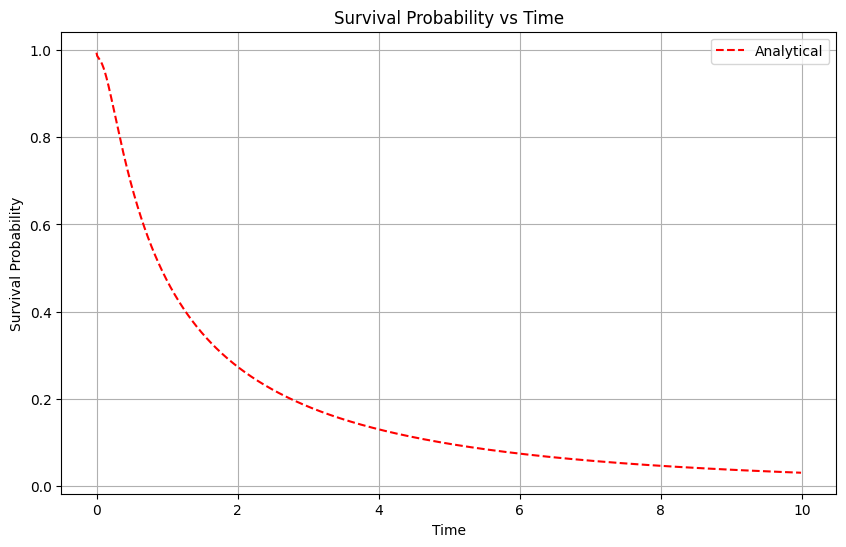

In [96]:
gamma = 1.0       # Absorption rate
L = 14.0          # Length of the domain
x0 = 13.5         # Initial position
k_r = 0.1           # Rate constant for right movement
k_u = 0.0001           # Rate constant for left movement
dt = 0.01         # Time step
T_max = 10.0       # Maximum simulation time
N_particles = 1000  # Number of particles to simulate
N_alpha = 200     # Number of alpha_n terms in the series
t_points = int(T_max / dt)  # Number of time points
t_array = np.arange(0, T_max, dt)

x_positions = np.linspace(0, L, 300)  # Positions for plotting
# Derived parameters
beta = 2 * (k_r - k_u)       # Beta parameter
c2 = k_u + k_r               # c^2 parameter
# c = np.sqrt(c2)              # c parameter
v = beta                     # Drift velocity

nuc_breath = Nucl_Breathing_Sol(v=v, 
                                c2=c2, 
                                L=L,
                                    t_values=t_array, 
                                    x_0=x0, 
                                    gamma=gamma,
                                    N_alpha=N_alpha)

analytical_S = nuc_breath.analytical_survival_probability()

plt.figure(figsize=(10, 6))
plt.plot(t_array, analytical_S, 'r--', label='Analytical')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Survival Probability vs Time')
plt.legend()
plt.grid()
plt.show()

In [53]:


def plot_phase_by_kbind(file_path: str, k_wrap: float, save_dir: str = None):
    """
    Plots heatmaps for metric, half_life, and decay_rate for each unique k_bind in the file.
    - file_path: Path to CSV file.
    - save_dir: Optional directory to save plots (saves as PNG per k_bind).
    """
    df = pd.read_csv(file_path)
    unique_k_bind = sorted(df['k_bind'].unique())

    for k in unique_k_bind:
        sub_df = df[df['k_bind'] == k]

        # Create figure with 3 subplots (one per value)
        fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
        fig.suptitle(f'Line Plots for k_bind={k}')

        ### Metric subplot
        sns.lineplot(data=sub_df, x='p_conc', y='metric', hue='coop', marker='o', ax=axs[0])
        axs[0].set_title('Metric vs p_conc')
        axs[0].set_xscale('log')
        axs[0].grid(True)

        ##### Half_life subplot
        sns.lineplot(data=sub_df, x='p_conc', y='half_life', hue='coop', marker='o', ax=axs[1])
        axs[1].set_title('Half Life vs p_conc')
        axs[1].set_xscale('log')
        axs[1].grid(True)

        ##### Decay_rate subplot
        sns.lineplot(data=sub_df, x='p_conc', y='decay_rate', hue='coop', marker='o', ax=axs[2])
        axs[2].set_title('Decay Rate vs p_conc')
        axs[2].set_xscale('log')
        axs[2].grid(True)

        plt.tight_layout()
        
        if save_dir:
            import os
            os.makedirs(save_dir, exist_ok=True)
            fig.savefig(os.path.join(save_dir, f'kwrap_{k_wrap}_line_kbind_{k}.png'))

        plt.show()



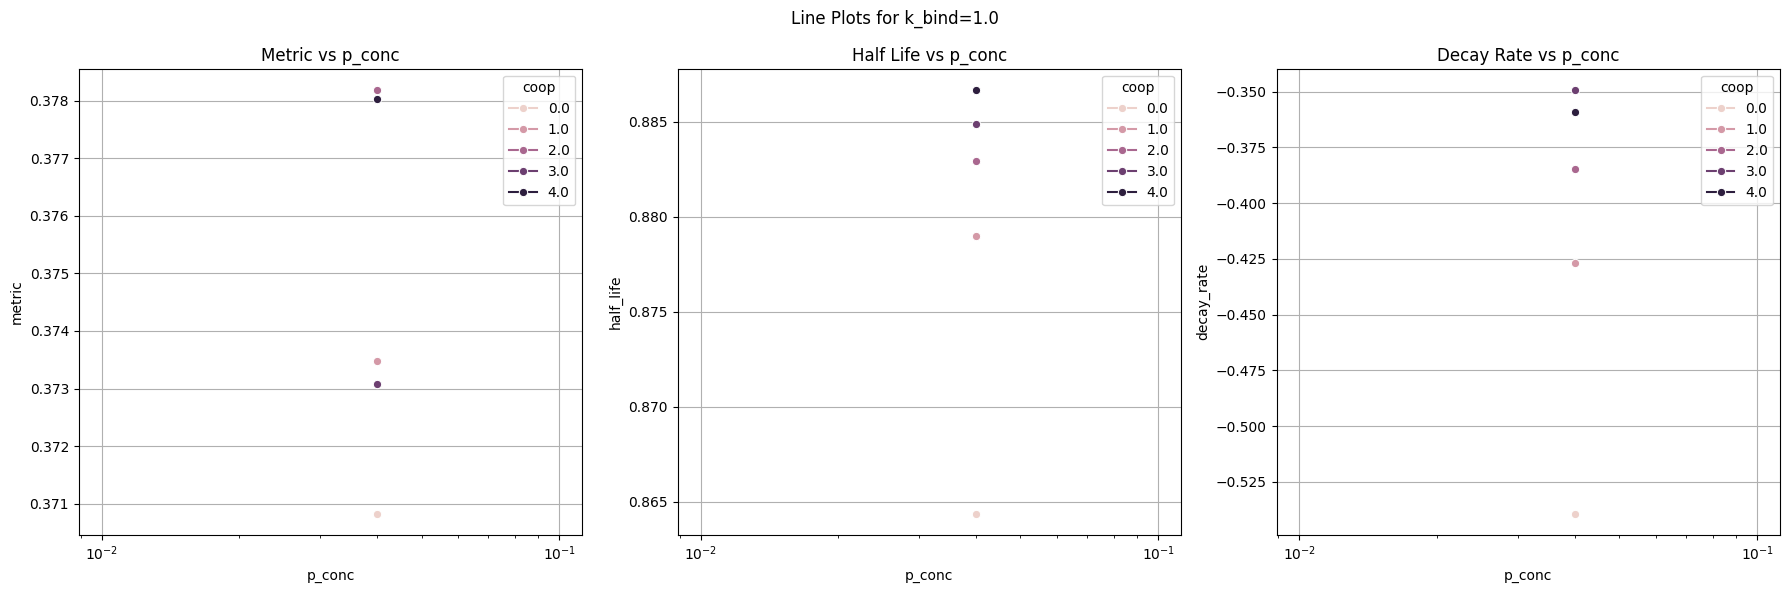

In [54]:
plot_phase_by_kbind(CLUSTER_OUTPUT_DIR/f"exactpoint_phase_space_metrics/phase_space_raw_metrics_{params1['k_wrap']}.csv", 
                    k_wrap=params1['k_wrap'], 
                   save_dir=CLUSTER_OUTPUT_DIR/f"exactpoint_phase_space_metrics/plots_{params1['k_wrap']}")

/tmp/ipykernel_2061746/4151305035.py:25: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(s_t, times)


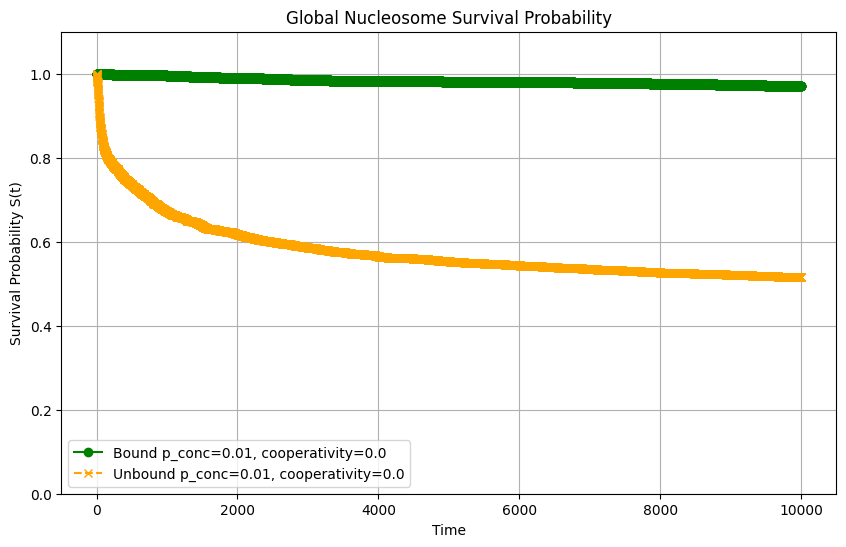

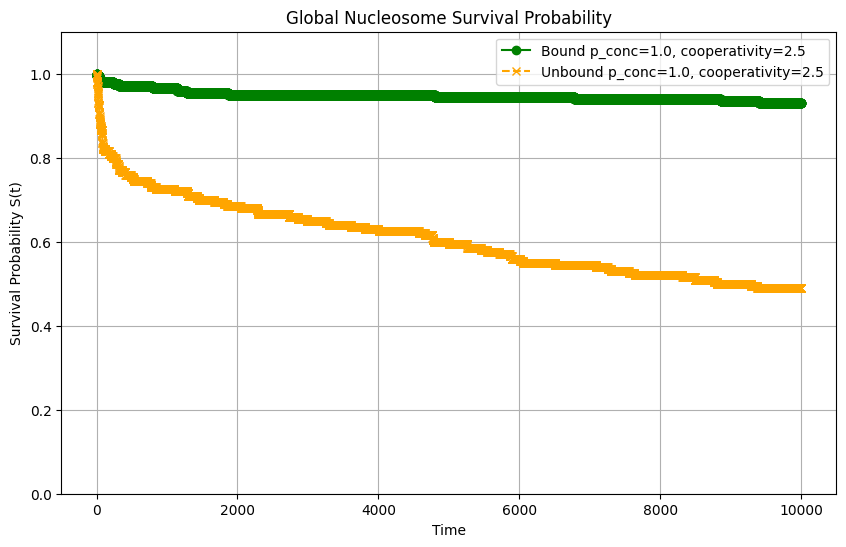

In [43]:
plt.figure(figsize=(10, 6))
# label1 = f"Bound p_conc={params2['prot_params']['p_conc']}, cooperativity={params2['prot_params']['cooperativity']}"
# label2 = f"Unbound p_conc={params2['prot_params']['p_conc']}, cooperativity={params2['prot_params']['cooperativity']}"
# plt.plot(times_bound2, probs_bound2, marker='o', linestyle='-', color='blue', label=label1)
# plt.plot(times_unbound2, probs_unbound2, marker='x', linestyle='--', color='red', label=label2)

label1 = f"Bound p_conc={params1['prot_params']['p_conc']}, cooperativity={params1['prot_params']['cooperativity']}"
label2 = f"Unbound p_conc={params1['prot_params']['p_conc']}, cooperativity={params1['prot_params']['cooperativity']}"
plt.plot(times_bound1, probs_bound1, marker='o', linestyle='-', color='green', label=label1)
plt.plot(times_unbound1, probs_unbound1, marker='x', linestyle='--', color='orange', label=label2)
plt.xlabel('Time')
plt.ylabel('Survival Probability S(t)')
plt.title('Global Nucleosome Survival Probability')
plt.ylim(0, 1.1)
plt.grid(True)
plt.legend()
plt.show()

In [102]:
p_conc = np.logspace(-2, 2, 10)  # Protamine concentration values
coop = np.linspace(0, 10, 10)  # Cooperativity values
k_bind = np.logspace(-2, 3, 6)  # Binding rate

p_conc_mesh, coop_mesh, k_bind_mesh = np.meshgrid(p_conc, coop, k_bind)

## **Local Runs**

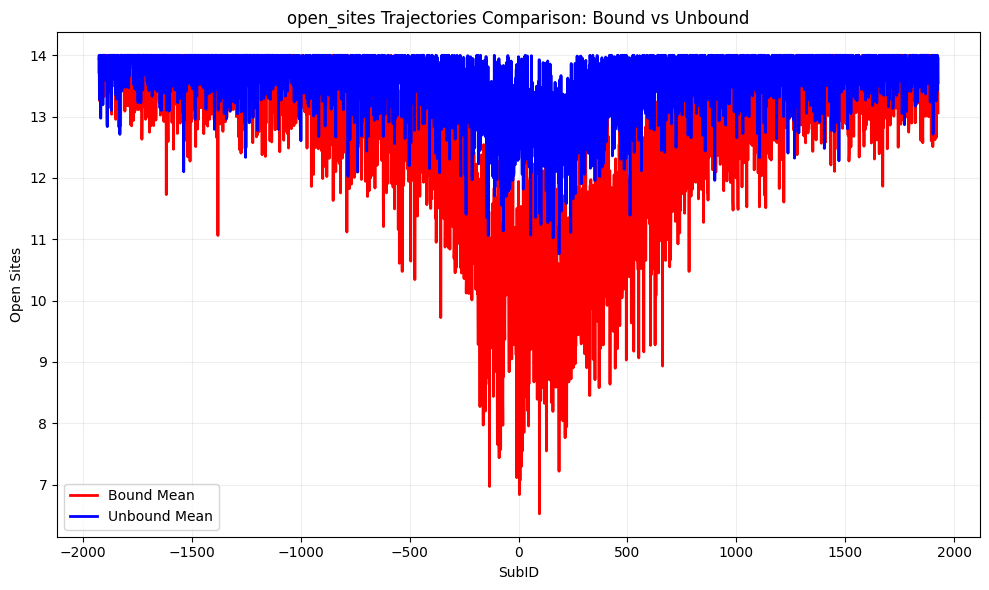

In [9]:

import seaborn as sns
bound_df = pd.read_csv(bound_summary, sep="\t")
unbound_df = pd.read_csv(unbound_summary, sep="\t")
shift_value = 73 - 2000

bound_df["subid"] = bound_df["subid"].astype(int) + shift_value
unbound_df["subid"] = unbound_df["subid"].astype(int) + shift_value
# Calculate mean trajectories for bound data
mean_bound = bound_df.groupby("subid", as_index=False)["cs_total"].mean()
mean_bound["open_sites"] = 14 - mean_bound["cs_total"]

# Calculate mean trajectories for unbound data (assuming similar column names)
mean_unbound = unbound_df.groupby("subid", as_index=False)["cs_total"].mean()
mean_unbound["open_sites"] = 14 - mean_unbound["cs_total"]

# Create the primary figure/axes for ΔF trajectories
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bound trajectories
sns.lineplot(
    data=mean_bound,
    x="subid",
    y="open_sites",
    color="red",
    linewidth=2,
    label="Bound Mean",
    ax=ax
)

# Plot unbound trajectories
sns.lineplot(
    data=mean_unbound,
    x="subid",
    y="open_sites",
    color="blue",
    linewidth=2,
    label="Unbound Mean",
    ax=ax
)

ax.set_xlabel("SubID")
ax.set_ylabel("Open Sites")
ax.set_title("open_sites Trajectories Comparison: Bound vs Unbound")
ax.grid(alpha=0.2)
ax.legend()
plt.tight_layout()
plt.show()

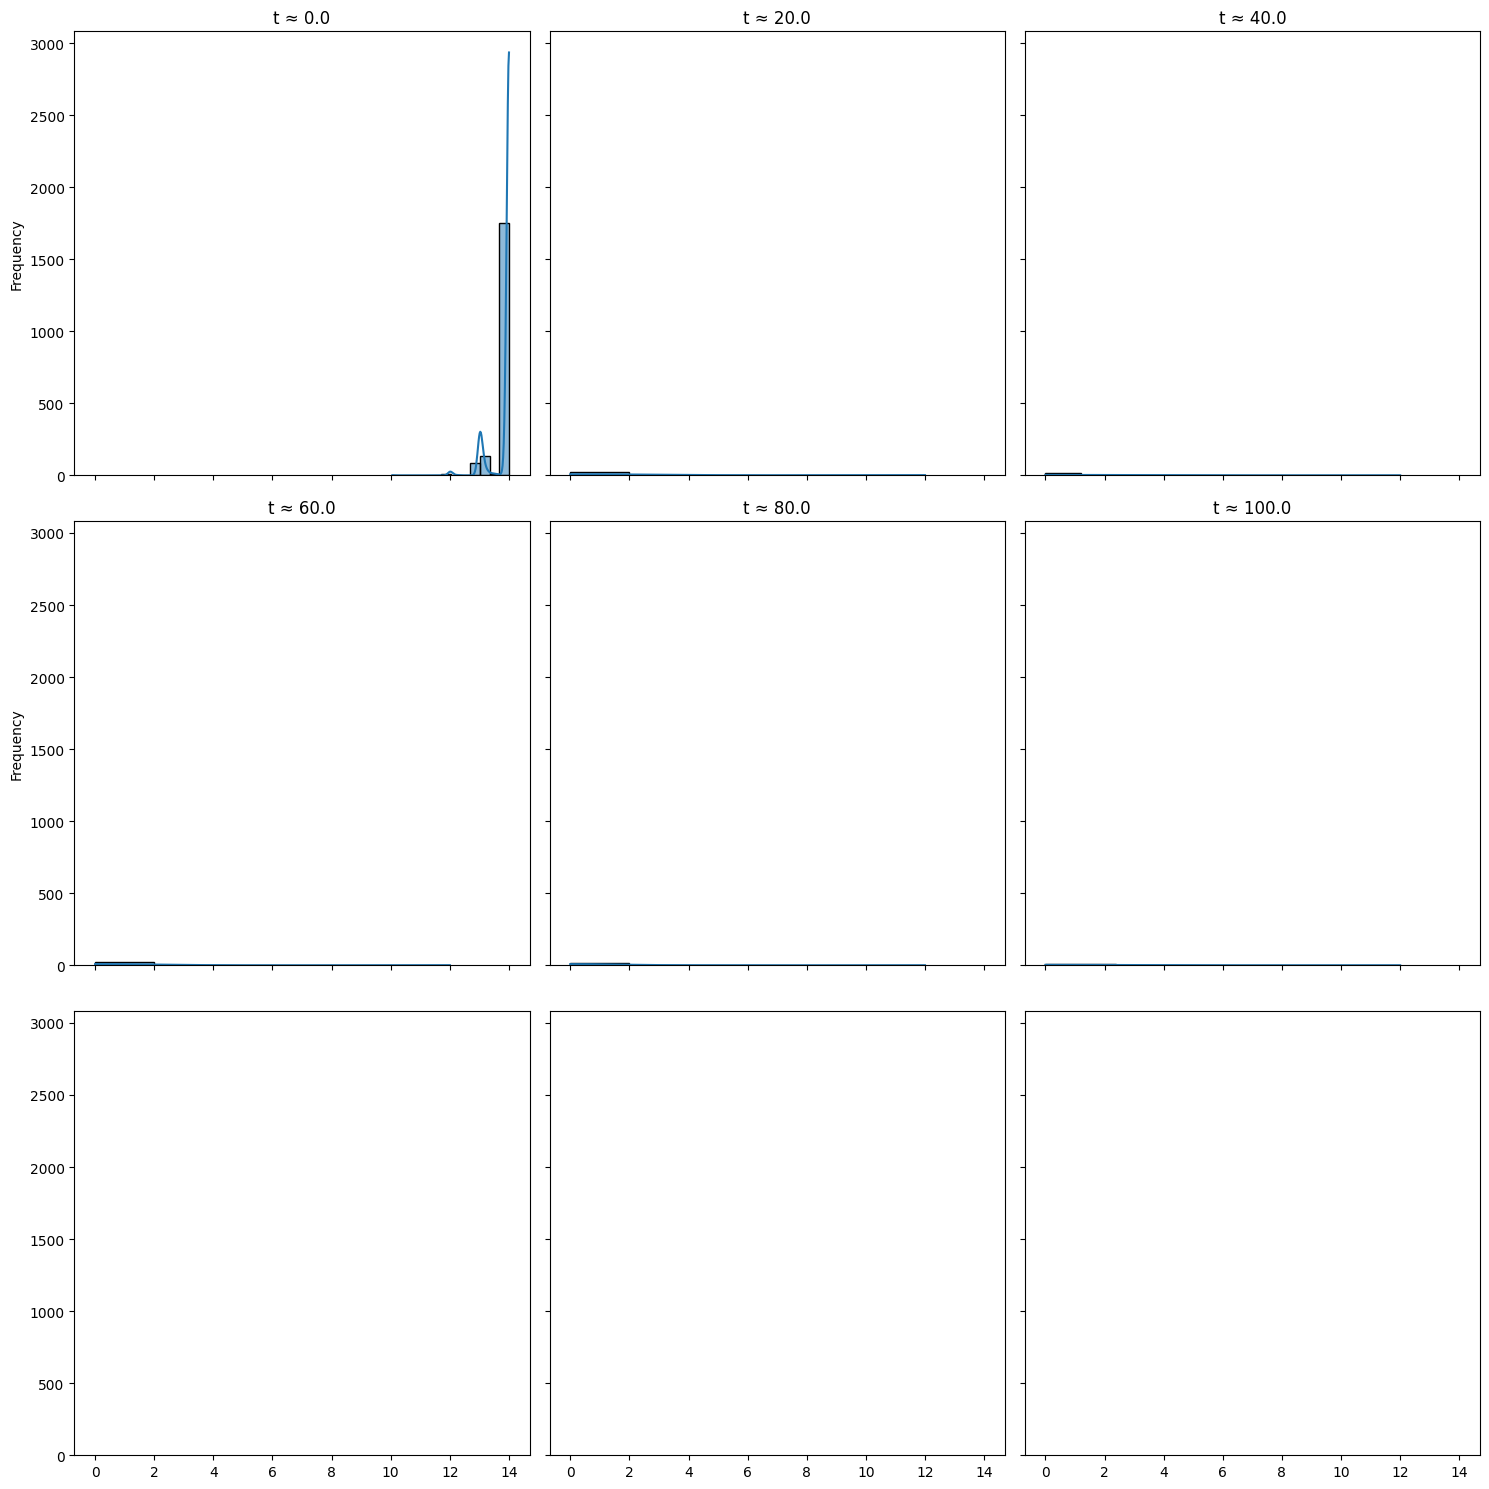

In [12]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def get_cs_total_at_approx_time(df_lazy: pl.LazyFrame, target_t: float, epsilon: float = 0.1):
    """
    Get cs_total values across all id/subid at times closest to target_t.
    Uses epsilon window around target_t; if no exact, takes nearest within window.
    Returns Polars Series of cs_total.
    """
    # Filter to time window [target_t - epsilon, target_t + epsilon]
    df_window = (df_lazy
                 .filter((pl.col('time') >= target_t - epsilon) & (pl.col('time') <= target_t + epsilon))
                 .collect(engine="streaming"))

    if df_window.is_empty():
        # No data in window; find global nearest time and use that
        nearest_time = (df_lazy
                        .select(pl.col('time').abs_sub(target_t).arg_min().alias('nearest_idx'))
                        .collect(engine="streaming")['nearest_idx'][0])
        df_nearest = df_lazy.filter(pl.col('time') == nearest_time).collect(engine="streaming")
        print(f"No data near {target_t}, using nearest time {nearest_time}")
        return df_nearest['cs_total']
    else:
        # Use mean cs_total per id/subid if multiple in window, or just take
        df_agg = (df_window
                  .group_by(['id', 'subid'])
                  .agg(pl.col('cs_total').mean())
                  .select('cs_total'))
        return df_agg['cs_total']

def plot_cs_distributions(parquet_path: str, t_max: float, step_size: float = 20.0, epsilon: float = 0.1):
    """
    Plot distributions of cs_total at time steps from 0 to t_max with given step_size.
    Handles approximate times with epsilon window or nearest fallback.
    """
    df_lazy = pl.scan_parquet(parquet_path)
    
    t_steps = np.arange(0, t_max + step_size, step_size)
    
    fig, axes = plt.subplots(len(t_steps) // 3 + 1, 3, figsize=(15, 5 * (len(t_steps) // 3 + 1)), sharex=True, sharey=True)
    axes = axes.flatten()
    
    for idx, t in enumerate(t_steps):
        cs_values = get_cs_total_at_approx_time(df_lazy, t, epsilon)
        if len(cs_values) == 0:
            print(f"No data for t ≈ {t}, skipping plot.")
            continue
        
        sns.histplot(cs_values.to_numpy(), kde=True, ax=axes[idx])
        axes[idx].set_title(f't ≈ {t}')
        axes[idx].set_xlabel('CS_TOTAL')
        axes[idx].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Usage example (adjust paths/values)

t_max = params["t_max"]  # Your simulation max time
dt = t_max / (params["t_steps"]-1)  # Time resolution based on t_max and t_steps

epsilon = 5 * dt # Time tolerance; adjust based on your time resolution
step_size = 20.0  # Steps of 20

plot_cs_distributions(bound_traj, t_max, step_size, epsilon)

In [ ]:
""""A systematic approach is to relate epsilon to the simulation's time resolution. 
For example, if your simulation runs from t = 0 to t_max with t_steps points, then the time resolution is approximately
  
    dt = t_max / (t_steps - 1).

You can then set epsilon as a multiple of dt. For instance, choosing

   epsilon = k * dt

with k a small constant (like 1-10) lets you control how much deviation around a target time you tolerate.
If t_max is 100 and t_steps is 50000, then dt is about 0.002 seconds. In that case, epsilon = 0.1 corresponds to k ≈ 50.
You might adjust k based on your system's dynamics and the precision you need."""

In [8]:
# schema = pl.Schema({
#     "id": pl.Utf8,
#     "subid": pl.Int16,    # subid < 6000 can fit in Int16
#     "time": pl.Float32,   # reduce precision from Float64 to Float32
#     "cs_total": pl.Int16, # maximum count 14 fits in Int16
#     "bprot": pl.Float32,
# })

# Read the parquet file using the provided schema
df_lazy = pl.scan_parquet(
    "/home/pol_schiessel/maya620d/pol/Projects/Codebase/Spermatogensis/src/scripts/001_0cop_trajectories.parquet"
    # schema=schema,
    # cast_options=pl.ScanCastOptions(integer_cast="best_effort")
)

In [9]:
num_ids =2
rng = np.random.default_rng(42)
unique_ids = df_lazy.select(pl.col('id').unique()).collect()['id'].to_list()
random_ids = rng.choice(unique_ids, size=num_ids, replace=False)

In [10]:
random_ids

array(['ENST00000354919.11', 'ENST00000374111.8'], dtype='<U18')

KeyboardInterrupt: 

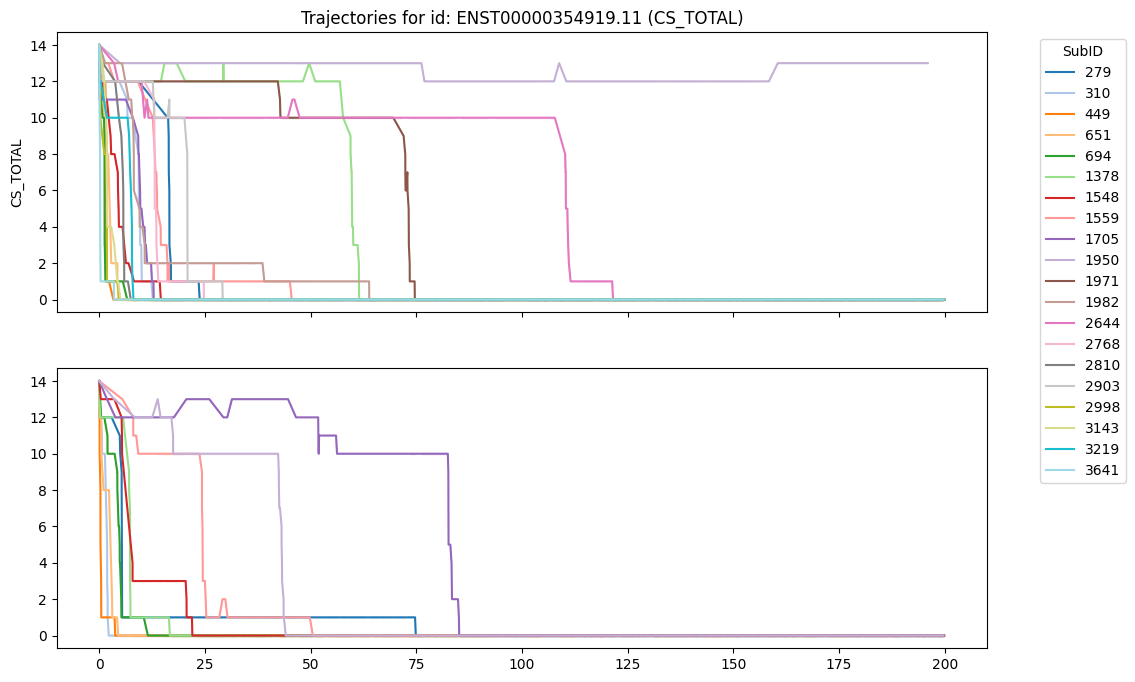

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(num_ids, 1, figsize=(12, 4 * num_ids), sharex=True)
if num_ids == 1:
    axes = [axes]  # Make iterable

for idx, id_ in enumerate(random_ids):
    # Filter for id, get unique subids
    subids_df = df_lazy.filter(pl.col('id') == id_).select(pl.col('subid').unique()).collect()
    unique_subids = subids_df['subid'].to_list()
    num_subids_per_id = 20  # Number of subids to plot per id
    selected_subids = rng.choice(unique_subids, size=num_subids_per_id, replace=False)
    
    # Lazy filter for id and selected subids, sort by time
    df_id = (df_lazy
                .filter((pl.col('id') == id_) & (pl.col('subid').is_in(selected_subids)))
                .sort(['subid', 'time'])
                .collect(engine="streaming"))
    
    # Plot using seaborn for lines per subid
    ax = axes[idx]
    sns.lineplot(data=df_id.to_pandas(), x='time', y="cs_total", hue='subid', ax=ax, palette='tab20')
    ax.set_title(f'Trajectories for id: {id_} (CS_TOTAL)')
    ax.set_xlabel('Time')
    ax.set_ylabel('CS_TOTAL')
    ax.legend(title='SubID', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [2]:
position_df

,id,subid,eq_cs_total,eq_bprot
0,ENST00000252936.8,679,0.0,13.9992
1,ENST00000252936.8,693,0.0,14.0000
2,ENST00000252936.8,704,0.0,13.9984
3,ENST00000252936.8,713,0.0,13.9992
4,ENST00000252936.8,724,0.0,13.9992
...,...,...,...,...
99883,ENST00000695737.1,2853,0.0,13.9984
99884,ENST00000695737.1,2864,0.0,14.0000
99885,ENST00000695737.1,2873,0.0,13.9988
99886,ENST00000695737.1,2883,0.0,13.9988


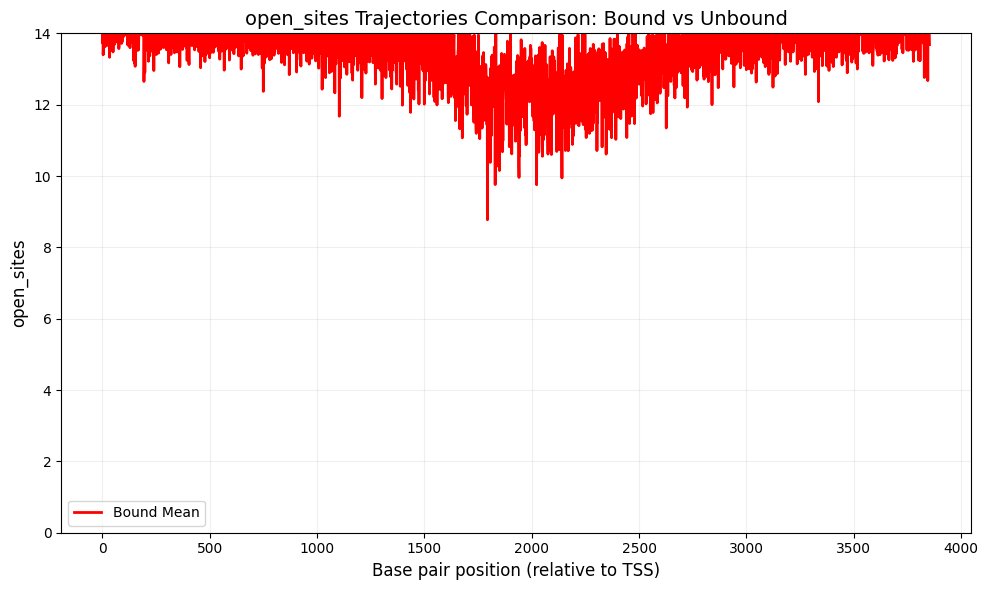

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
position_df = pd.read_csv("/home/pol_schiessel/maya620d/pol/Projects/Codebase/Spermatogensis/src/scripts/001.tsv", sep="\t")

# Create the primary figure/axes for ΔF trajectories
fig, ax1 = plt.subplots(figsize=(10, 6))

# Calculate and plot mean trajectories
mean_bound = position_df.groupby("subid", as_index=False)["eq_cs_total"].mean()
mean_bound["open_sites"] = 14 - mean_bound["eq_cs_total"]  # Assuming open sites are half of bound sites
# mean_unbound = position_df.groupby("subid", as_index=False)["dF"].mean()

sns.lineplot(
    data=mean_bound,
    x="subid",
    y="open_sites",
    color="red",
    linewidth=2,
    label="Bound Mean",
    ax=ax1
)
# sns.lineplot(
#     data=mean_unbound,
#     x="subid",
#     y="dF",
#     color="green",
#     linewidth=2,
#     label="Unbound Mean",
#     ax=ax1
# )

ax1.set_xlabel("Base pair position (relative to TSS)", fontsize=12)
ax1.set_ylabel("open_sites", fontsize=12)
ax1.set_title("open_sites Trajectories Comparison: Bound vs Unbound", fontsize=14)
ax1.grid(alpha=0.2)
ax1.set_ylim(0, 14)

# # Create a secondary y-axis for the TSS density plot
# ax2 = ax1.twinx()
# sns.kdeplot(
#     data=prom_bound_df_merged,
#     x="dist_TSS",
#     fill=True,
#     color='mediumpurple',
#     alpha=0.7,
#     linewidth=2,
#     ax=ax2
# )
# ax2.axvline(0, color='black', linestyle='--', linewidth=1.5)
# ax2.set_ylabel("Density", fontsize=12)
# ax2.get_xlim()
# ax2.set_xlim(-2100, 2100)  # Adjust the x-axis limits

fig.tight_layout()

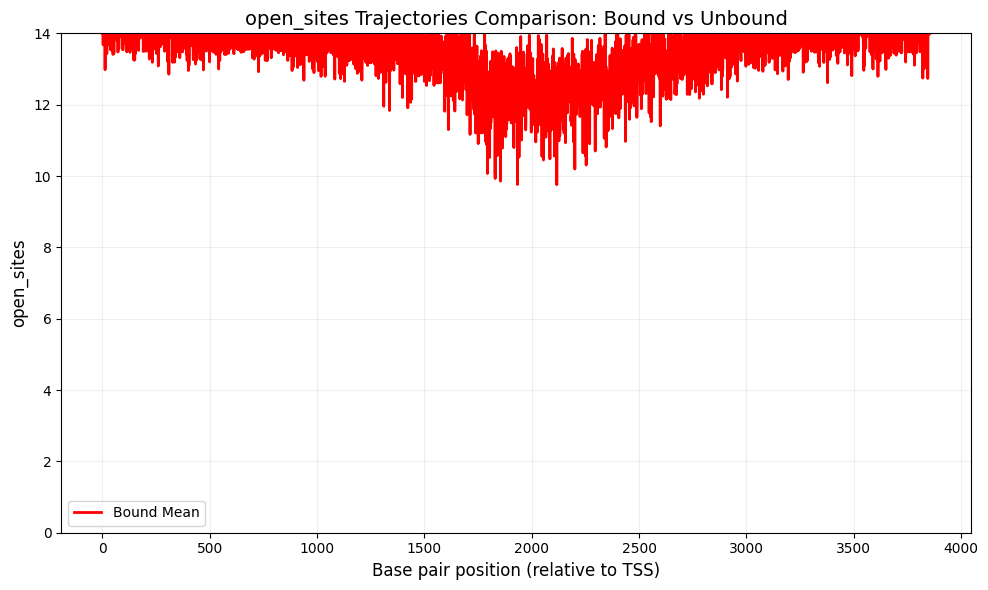

In [4]:

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
position_df = pd.read_csv("/home/pol_schiessel/maya620d/pol/Projects/Codebase/Spermatogensis/src/scripts/001_0cop.tsv", sep="\t")

# Create the primary figure/axes for ΔF trajectories
fig, ax1 = plt.subplots(figsize=(10, 6))

# Calculate and plot mean trajectories
mean_bound = position_df.groupby("subid", as_index=False)["eq_cs_total"].mean()
mean_bound["open_sites"] = 14 - mean_bound["eq_cs_total"]  # Assuming open sites are half of bound sites
# mean_unbound = position_df.groupby("subid", as_index=False)["dF"].mean()

sns.lineplot(
    data=mean_bound,
    x="subid",
    y="open_sites",
    color="red",
    linewidth=2,
    label="Bound Mean",
    ax=ax1
)
# sns.lineplot(
#     data=mean_unbound,
#     x="subid",
#     y="dF",
#     color="green",
#     linewidth=2,
#     label="Unbound Mean",
#     ax=ax1
# )

ax1.set_xlabel("Base pair position (relative to TSS)", fontsize=12)
ax1.set_ylabel("open_sites", fontsize=12)
ax1.set_title("open_sites Trajectories Comparison: Bound vs Unbound", fontsize=14)
ax1.grid(alpha=0.2)
ax1.set_ylim(0, 14)

# # Create a secondary y-axis for the TSS density plot
# ax2 = ax1.twinx()
# sns.kdeplot(
#     data=prom_bound_df_merged,
#     x="dist_TSS",
#     fill=True,
#     color='mediumpurple',
#     alpha=0.7,
#     linewidth=2,
#     ax=ax2
# )
# ax2.axvline(0, color='black', linestyle='--', linewidth=1.5)
# ax2.set_ylabel("Density", fontsize=12)
# ax2.get_xlim()
# ax2.set_xlim(-2100, 2100)  # Adjust the x-axis limits

fig.tight_layout()

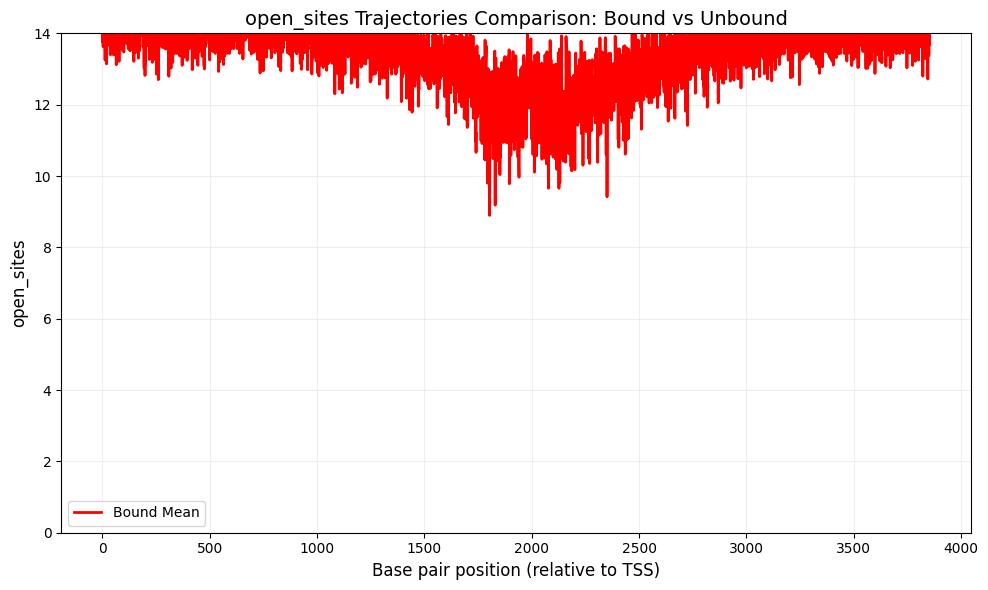

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
position_df = pd.read_csv("/home/pol_schiessel/maya620d/pol/Projects/Codebase/Spermatogensis/src/scripts/001_.1_0cop.tsv", sep="\t")

# Create the primary figure/axes for ΔF trajectories
fig, ax1 = plt.subplots(figsize=(10, 6))

# Calculate and plot mean trajectories
mean_bound = position_df.groupby("subid", as_index=False)["eq_cs_total"].mean()
mean_bound["open_sites"] = 14 - mean_bound["eq_cs_total"]  # Assuming open sites are half of bound sites
# mean_unbound = position_df.groupby("subid", as_index=False)["dF"].mean()

sns.lineplot(
    data=mean_bound,
    x="subid",
    y="open_sites",
    color="red",
    linewidth=2,
    label="Bound Mean",
    ax=ax1
)
# sns.lineplot(
#     data=mean_unbound,
#     x="subid",
#     y="dF",
#     color="green",
#     linewidth=2,
#     label="Unbound Mean",
#     ax=ax1
# )

ax1.set_xlabel("Base pair position (relative to TSS)", fontsize=12)
ax1.set_ylabel("open_sites", fontsize=12)
ax1.set_title("open_sites Trajectories Comparison: Bound vs Unbound", fontsize=14)
ax1.grid(alpha=0.2)
ax1.set_ylim(0, 14)

# # Create a secondary y-axis for the TSS density plot
# ax2 = ax1.twinx()
# sns.kdeplot(
#     data=prom_bound_df_merged,
#     x="dist_TSS",
#     fill=True,
#     color='mediumpurple',
#     alpha=0.7,
#     linewidth=2,
#     ax=ax2
# )
# ax2.axvline(0, color='black', linestyle='--', linewidth=1.5)
# ax2.set_ylabel("Density", fontsize=12)
# ax2.get_xlim()
# ax2.set_xlim(-2100, 2100)  # Adjust the x-axis limits

fig.tight_layout()